In [1]:
# !pip install geopandas
# !pip install pyproj==1.9.6
# !conda install -c anaconda basemap

## For Mac:
# brew install geos
# pip3 install https://github.com/matplotlib/basemap/archive/master.zip
#
## For Ubuntu:
# sudo apt-get install geos
# sudo pip3 install https://github.com/matplotlib/basemap/archive/master.zip

# !pip install wordcloud

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from mpl_toolkits.basemap import Basemap
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn import metrics

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial import distance_matrix
from datetime import datetime

In [4]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# Property Sales 2002-2005, Minneapolis: A Clustering Analysis

_Nikolay Vasilev, [nikolay.vasilev@gmail.com](mailto:nikolay.vasilev@gmail.com)_ \
_Software University, Bulgaria_ \
 _23 November 2019_

## Abstract

`WIP`

This work attempts to create a framework for clustering analysis using publicly available property sales data from Minneapolis, Minnesota, USA, for the period 2002-2005.

The methodology used is as follows: initial data features are initially analysed and only a subset of them is selected for the actual analysis, based on the quality of the data available for each feature as well as their relevance to the conducted analysis. After a standard set of pre-processing actions such as de-duplication, scaling, indicator variables creation and Principal Component Analysis (PCA), clustering analysis is applied using various algorithms, namely KMeans++ Clustering, Agglomerative Clustering and Density Based Clustering (DBSCAN) with the accompanying visual methods for clustering verification such as Elbow Method, dendrogram diagrams and cluster silhouette profiles.

Several approaches are tested in order to explain the results from the clustering, to only show that the clustering of the property sales for the given period is not purely geographically defined but other factors such as property type are important as well.

**Keywords**: machine learning, clustering analysis, feature selection, feature creation, de-duplication, scaling, PCA, principal component analysis, KMeans++ clustering, agglomerative clustering, density based clustering analysis, DBSCAN, elbow method, dendrogram, cluster silhouette profile, word cloud, pivot table

## Introduction

`WIP`

_**Introduction: What did you/others do? Why did you do it?**_

Now-a-days property market is hard to be imagined without the usage of information technologies and yet too few actors on the market use data-driven approach when purchasing new properties. One of the advantages of the age we are living in is the abundance of data available to us and the data-processing tools which are at our disposal which we could use to harness the insights we could find in that data.

The Minneapolis Assessor's Office tracks and records every real property transaction in the city as also it makes this information public. This work attempts to create a framework for data processing which would help property buyers and investors to use data-driven approach, based on previous years property sales information, when purchasing properties. This work also lays the foundation for automating the analysis of the properties sales in the city giving valuable insights to other interested parties as well.

The work is organised as follows: 

initial data features are analysed and only a subset of them is selected for the actual analysis is selected, based on the quality of the data available for each feature as well as their relevance to the conducted analysis. After a standard set of preprocessing actions such as deduping, scaling, indicator variables creation and Principal Component Analysis (PCA), clustering analysis is applied using various approaches such as KMeans++, Agglomerative and Density Based Clustering (DBSCAN) analysis. Various approaches are used to explain the results from the clustering, to only show that the clustering of the property sales is not purely geographically defined and other factors such as property type are important as well. 


DESCRIPTION
The Minneapolis Assessor's Office tracks and records every real property transaction in the city.

- Introduction
//- Clustering Approaches: Overview
- Data Overview
- Data Pre-processing
- Finding Optimal Number of Clusters
- Cluster Generation
- Clustering Results: Analysis
- Conclusions
- Feature Work
- References

## Methodology

_**Methods: How did you do it?**_

`WIP`

TODO: Add short description for each of the following:
- feature selection/creation
- de-duplication
- scaling
- indicator variables creation 
- Principal Component Analysis (PCA)
- KMeans++ Clustering
- Agglomerative Clustering 
- Density Based Clustering (DBSCAN)
- Elbow Method
- dendrogram diagrams 
- cluster silhouette profiles
- word cloud
- pivot tables

## Data Pre-processing

`WIP`

The Minneapolis Assessor's Office tracks and records every real property transaction in the city. This is public information. Attributes included in the dataset are as follows:

* **CRV** - Certificate of Real Estate Value number. A unique identifier given to every certificate of real estate value
* **PIN** - the 13-digit tax ID that uniquely identifies a taxable parcel
* **Sale_Date** - the date of the sale
* **InRTOStudy** - yes or no depending on whether the sale was used for the Minnesota Department of Revenue Sales Ratio Study. Only sales that are considered fair market value sales are included
* **Neighborhood** - the name of the neighborhood the property is in
* **Ward** - the number of the ward that the property is in
* **Address** - the street address of the property
* **Grantee** - the buyer name
* **Grantor** - the seller name
* **Adjusted_Sale_Price** - the sale price after accounting for seller-paid adjustments
* **Gross_Sale_Price** - the unadjusted sale price
* **Downpayment** - the dollar value of the initial downpayment 
* **X** - the X coordinate of the parcel centroid of the sold property 
* **Y** - the Y coordinate of the parcel centroid of the sold property 
The coordinates are expressed in the NAD 83 Hennepin County HARN coordinate system (WKID: 103734)

We need to sanitise and prepare the input data before running it through a clustering analysis.

### Data Loading

We load only the `.geo` file from all available files as it contains the majority of features we need for our analysis. 

In [5]:
property_sales = gpd.read_file('./data/property-sales-2002-2005-1-1.geo')

In [6]:
property_sales.shape

(60906, 24)

In [7]:
property_sales.dtypes

OBJECTID                 int64
CRV                    float64
PIN                     object
Sale_Date               object
InRTOStudy              object
Neighborhood            object
Ward                     int64
PropType                object
Address                 object
HouseNumber              int64
HouseNumber2            object
PrefixDirection         object
StreetName              object
StreetType              object
SuffixDirection         object
Grantee                 object
Grantor                 object
Adjusted_Sale_Price    float64
Gross_Sale_Price       float64
SaleDate                object
Downpayment             object
X                      float64
Y                      float64
geometry                object
dtype: object

### Renaming Dataset Features

As the column names are not following any specific naming convention and as we are using Python-based tools for the analysis, we are renaming them to be compliant with the Python naming convention (lowercase words separated by underscores) as well to increase the readability.

In [8]:
property_sales.columns = ['object_id', 'crv', 'pin', 'sale_date', 'in_rto_study', 'neighborhood','ward', 'prop_type', 'address', 'house_number', 'house_number_2', 'prefix_direction', 'street_name', 'street_type', 'suffix_direction', 'grantee', 'grantor', 'adjusted_sale_price', 'gross_sale_price', 'sale_date_2', 'downpayment', 'x', 'y', 'geometry']

### Removing Duplicate Samples

After a brief exploration we observe that there are samples in the dataset which are semantically are identical with others. For the purpose we use `cvr` which is a unique identifier given to every certificate of real estate value as well as `pin`, which is a 13-digit tax ID that uniquely identifies a taxable parcel.

In [9]:
property_sales.crv.duplicated().tail()

60901     True
60902     True
60903    False
60904     True
60905     True
Name: crv, dtype: bool

We could see that few of the last records in the datasets have duplicates, so we list them in order to examine one of them:

In [10]:
property_sales.tail()

,object_id,crv,pin,sale_date,in_rto_study,neighborhood,ward,prop_type,address,house_number,house_number_2,prefix_direction,street_name,street_type,suffix_direction,grantee,grantor,adjusted_sale_price,gross_sale_price,sale_date_2,downpayment,x,y,geometry
60901,44996,798354.0,"""1602824410089""",2002-05-30T00:00:00,Yes,LYNNHURST,13,Residential,5124 Lyndale AVE S,5124,NULL,NULL,Lyndale,AVE,S,Janice Schlueter,S K Eliot,374900.0,374900.0,2002-05-30T00:00:00,NULL,524522.515313,143240.480606,POINT (-93.28868858475667 44.90966498025884)
60902,44997,798354.0,"""1602824410089""",2002-05-30T00:00:00,Yes,LYNNHURST,13,Residential,5124 Lyndale AVE S,5124,NULL,NULL,Lyndale,AVE,S,Janice Schlueter,J L Jackson,374900.0,374900.0,2002-05-30T00:00:00,NULL,524522.515313,143240.480606,POINT (-93.28868858475667 44.90966498025884)
60903,44998,843373.0,"""1502824320088""",2003-10-29T00:00:00,Yes,TANGLETOWN,11,Residential,5125 Lyndale AVE S,5125,NULL,NULL,Lyndale,AVE,S,Harald F Markley,Philip B Mortenson,520000.0,520000.0,2003-10-29T00:00:00,NULL,524758.888767,143145.589919,POINT (-93.28777673416567 44.90940397069721)
60904,44999,825655.0,"""1502824320024""",2003-04-23T00:00:00,Yes,TANGLETOWN,11,Residential,5135 Lyndale AVE S,5135,NULL,NULL,Lyndale,AVE,S,David L Mccoid II,Alex A Schmit,289900.0,289900.0,2003-04-23T00:00:00,NULL,524721.193954,143032.813184,POINT (-93.28792272922331 44.90909478915032)
60905,45000,825655.0,"""1502824320024""",2003-04-23T00:00:00,Yes,TANGLETOWN,11,Residential,5135 Lyndale AVE S,5135,NULL,NULL,Lyndale,AVE,S,David L Mccoid II,Zeke T Rice,289900.0,289900.0,2003-04-23T00:00:00,NULL,524721.193954,143032.813184,POINT (-93.28792272922331 44.90909478915032)


A concrete example of a duplicate sample is a property sale with `crv` equal to `798354`:

In [11]:
property_sales[property_sales.crv == 798354.0]

,object_id,crv,pin,sale_date,in_rto_study,neighborhood,ward,prop_type,address,house_number,house_number_2,prefix_direction,street_name,street_type,suffix_direction,grantee,grantor,adjusted_sale_price,gross_sale_price,sale_date_2,downpayment,x,y,geometry
60899,44994,798354.0,"""1602824410089""",2002-05-30T00:00:00,Yes,LYNNHURST,13,Residential,5124 Lyndale AVE S,5124,NULL,NULL,Lyndale,AVE,S,Joseph F Obrien,S K Eliot,374900.0,374900.0,2002-05-30T00:00:00,NULL,524522.515313,143240.480606,POINT (-93.28868858475667 44.90966498025884)
60900,44995,798354.0,"""1602824410089""",2002-05-30T00:00:00,Yes,LYNNHURST,13,Residential,5124 Lyndale AVE S,5124,NULL,NULL,Lyndale,AVE,S,Joseph F Obrien,J L Jackson,374900.0,374900.0,2002-05-30T00:00:00,NULL,524522.515313,143240.480606,POINT (-93.28868858475667 44.90966498025884)
60901,44996,798354.0,"""1602824410089""",2002-05-30T00:00:00,Yes,LYNNHURST,13,Residential,5124 Lyndale AVE S,5124,NULL,NULL,Lyndale,AVE,S,Janice Schlueter,S K Eliot,374900.0,374900.0,2002-05-30T00:00:00,NULL,524522.515313,143240.480606,POINT (-93.28868858475667 44.90966498025884)
60902,44997,798354.0,"""1602824410089""",2002-05-30T00:00:00,Yes,LYNNHURST,13,Residential,5124 Lyndale AVE S,5124,NULL,NULL,Lyndale,AVE,S,Janice Schlueter,J L Jackson,374900.0,374900.0,2002-05-30T00:00:00,NULL,524522.515313,143240.480606,POINT (-93.28868858475667 44.90966498025884)


We observe that the property sale is the same, but there are four records for it, because there are two sellers (`grantor`s) and two buyers (`grantee`s) in the purchase.

First we will sort the properties by `crv` and then we will de-duplicate by both `crv` and `pin`:

In [12]:
property_sales_deduped = property_sales
property_sales_deduped.sort_values(by=['crv'], inplace = True)

In [13]:
property_sales_deduped.drop_duplicates(subset = ['crv'], keep = False, inplace = True) 
property_sales_deduped.drop_duplicates(subset = ['pin'], keep = False, inplace = True) 

We could observe that there are no duplicated records by none of the unique features of the dataset - `crv` and `pin`: 

In [14]:
property_sales_deduped.crv.duplicated().any()

False

In [15]:
property_sales_deduped.pin.duplicated().any()

False

In [16]:
property_sales_deduped.sort_values(by=['object_id'], inplace = True)
property_sales = property_sales_deduped.sort_index()

We observe that the size of the data set now has reduced drasticaly to `33%` of the initial size:

In [17]:
property_sales.shape

(20550, 24)

### Features Pre-Processing

In the next sections we go through each of the available features and analyse whether its data is in a sufficiently good shape for the follow-up clustering.

For convenience, we group the available features in six groups during the analysis, each of which correspond to the sections below:
* identifiers/category
* address
* sale date
* sale participants
* sale price
* geo-related

#### Processing Idenfier/Category Related Features

##### `object_id`

`object_id` values are unique, therefore they are not influencing the clustering results, hence they would not be included in the clustering analysis.

In [18]:
len(property_sales.object_id.unique())

20550

##### `crv`

`crv` (or Certificate of Real Estate Value number, a unique identifier given to every certificate of real estate value) is formally of a numeric type, but as its values are all unique, this makes it a category variable, which if later is converted into a list of indicator (dummy) variables it will increase the dimensionality of the dataset disproportionally to the number of samples available, thus reducing the precision. For that reason this feature, similarly to the `object_id` will be excluded from the analysis.
A few checks below prove our reasoning.

In [19]:
len(property_sales.crv.unique())

20550

##### `pin`

Similarly to `crv` and `object_id`, `pin` is an identifier, therefore we are excluding it it as a feasible feature for clustering:

In [20]:
len(property_sales.pin.unique())

20550

##### `in_rto_study`

In [21]:
len(property_sales.in_rto_study.unique())

2

In [22]:
property_sales[property_sales.in_rto_study.isna()].shape

(0, 24)

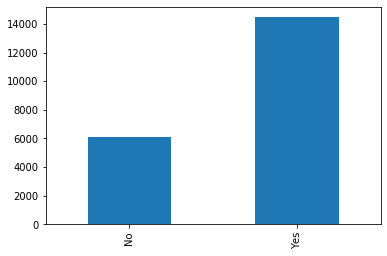

In [23]:
ward_value_counts = property_sales.in_rto_study.value_counts(sort = False).plot.bar()

As this feature is boolean in its nature from puerly technical perspective it is suitable to be used in the analysis. 

Please note that from purely domain-related standpoint, it does not seem to influence the property sales, but as the we are not enough property sales domain-versed, we would leave this feature during the clustering with the idea that if it is not important it would be ignored after the PCA step anyway.   

##### `ward`

In [24]:
property_sales[property_sales.ward.isna()].shape

(0, 24)

In [25]:
len(property_sales.ward.unique()) 

13

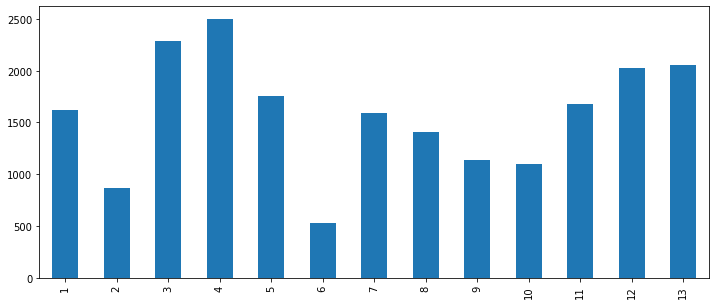

In [26]:
plt.figure(figsize=(12,5))
ward_value_counts = property_sales.ward.value_counts(sort = False).plot.bar()

This is a category variable with fairly small number of categories (just `13`), so we are going to leave it during the clustering. If it makes the model computation difficult or incorrect, then we will exclude it at a later step.

#### Processing Address Related Features

In the sections below we will review whether the address related features from the input dataset are suitable for the clustering analysis.

##### `address`

In [27]:
property_sales[property_sales.address.isna()].shape

(0, 24)

In [28]:
len(property_sales.address.unique())

20550

In [29]:
property_sales.address.unique()

array(['19 1ST ST S #B2005', '19 1ST ST S #B-608', '19 1ST ST S #B2708',
       ..., '5051 Lyndale AVE S', '5067 Lyndale AVE S',
       '5125 Lyndale AVE S'], dtype=object)

This feature seems to be a combination of `house_number`, `street_name`, `street_type` and post code features. As it is hard to be used for clustering purposes, it will be excluded from the follow-up analysis.

##### `house_number` and `house_number_2`

Reviewing `house_number` and `house_number_2` columns we could see that both columns are irrelevant to our study.

The available values for `house_number` are only about `16%`:

In [30]:
property_sales.house_number.unique()

array([  19,  110,  121, ..., 3203, 4757, 5067])

In [31]:
len(property_sales.house_number.unique())/len(property_sales)

0.1672992700729927

Similarly `house_number_2` contains values which do not seem relevant to our analysis:

In [32]:
property_sales.house_number_2.unique()

array(['NULL', ' 1/2', ' H', '-5415'], dtype=object)

As a conclusion, both features will not be included into the clustering analysis.

##### `street_name`

In [33]:
property_sales[property_sales.street_name.isna()].shape

(0, 24)

In [34]:
len(property_sales.street_name.unique())

354

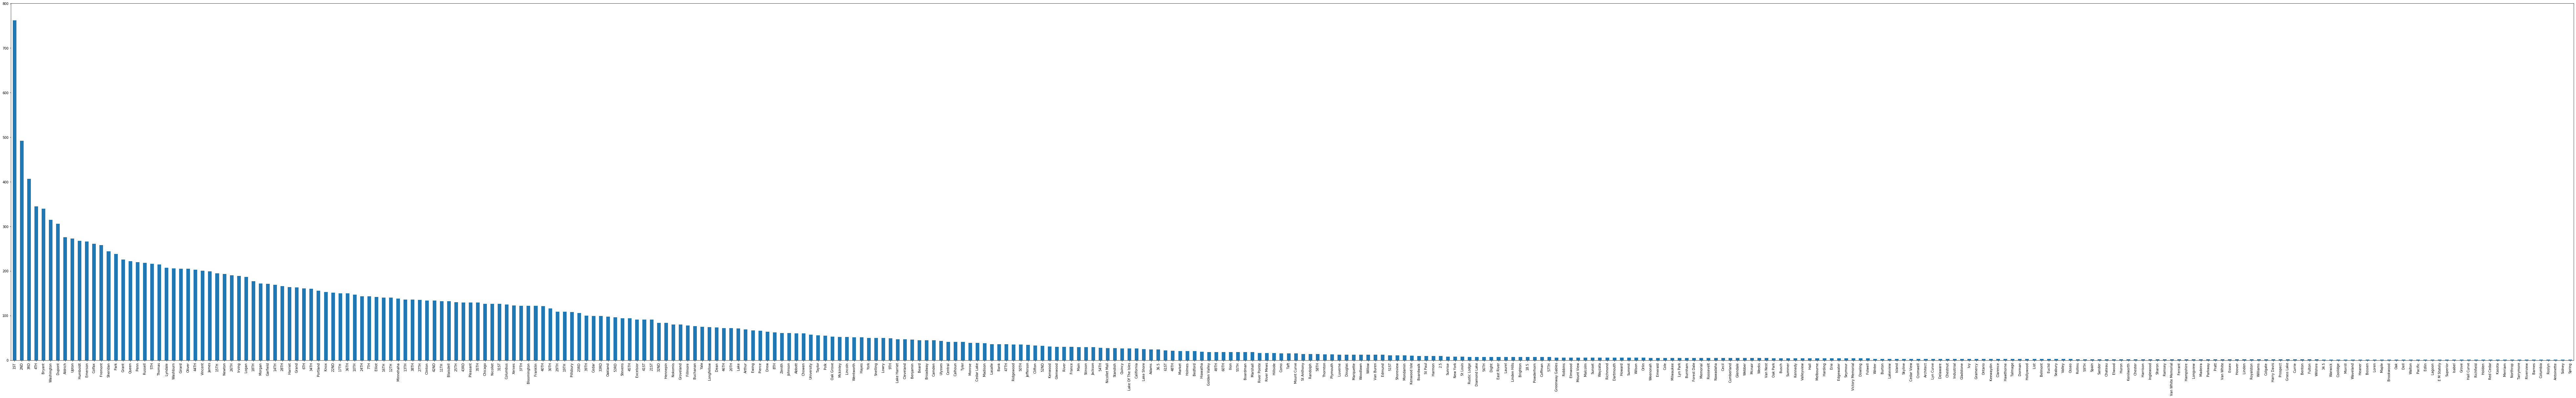

In [35]:
plt.figure(figsize=(140,20))
property_sales.street_name.value_counts(sort = True).plot.bar()

The initial idea during analysis of the input dataset was to preserve the `street_name` feature, as it seems that some streets are more popular than others, i.e. from domain point of view streets are important, but when we create indicator variables the number of dataset features is increasing several times, i.e. from `114` to `479`, which considering the small size of the dataset (`60906` before de-duplication and `20550` afterwards) is not a viable solution as it will decrease the precision of the clustering. 

That is why, `street_name` would be removed from the list of features to be used for clustering. When there is more input data (e.g. samples number larger than at least `100000`), then we could reconsider our decision and include `street_name` as anoter feature to our analysis.

##### `neighbourhood`

In [36]:
property_sales[property_sales.neighborhood.isna()].shape

(0, 24)

In [37]:
len( property_sales.neighborhood.unique())

87

In [38]:
 property_sales.neighborhood.value_counts(sort=False)

LORING PARK         356
FOLWELL             453
BRYN MAWR           164
CORCORAN            255
FULTON              397
                   ... 
ARMATAGE            334
EAST ISLES          179
CARAG               242
MIDTOWN PHILLIPS    161
KING FIELD          425
Name: neighborhood, Length: 87, dtype: int64

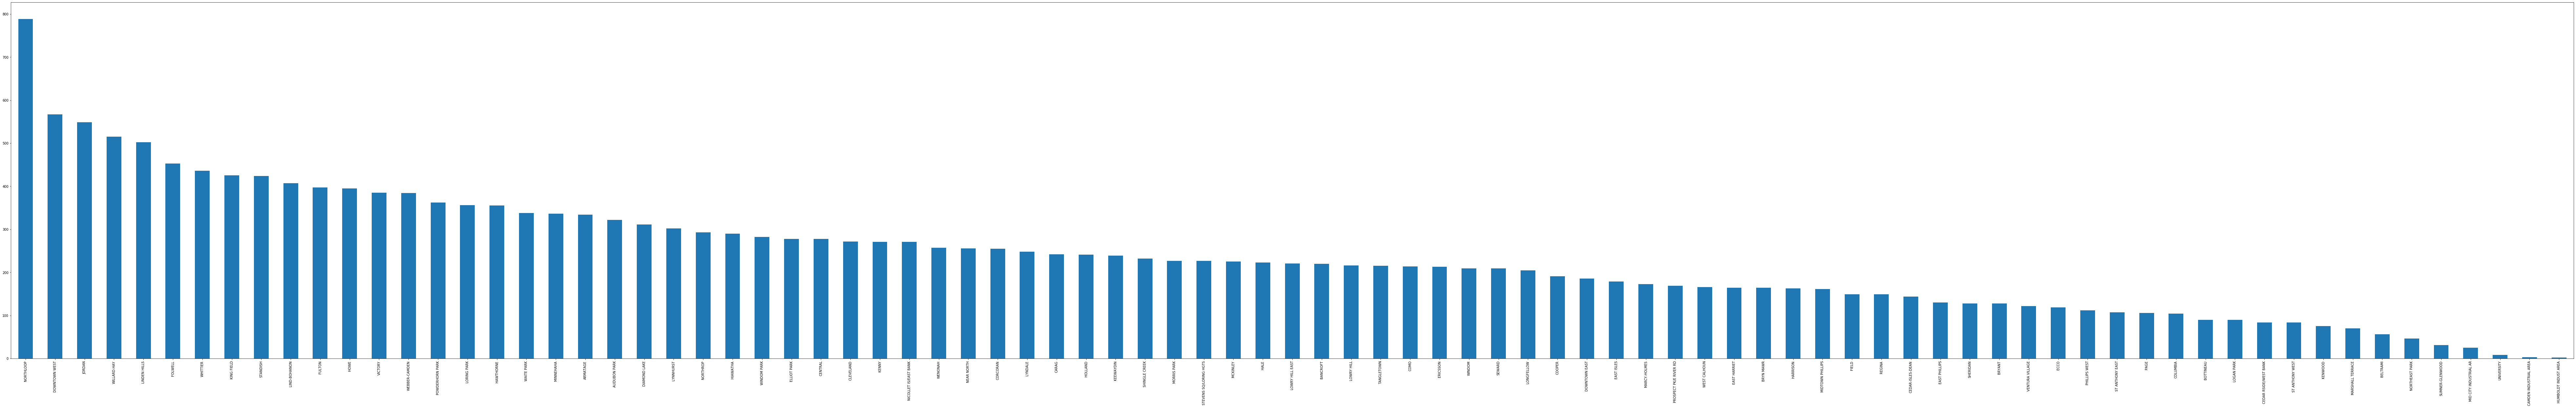

In [39]:
plt.figure(figsize=(140,20))
property_sales.neighborhood.value_counts(sort=True).plot.bar()

`neighbourhood` is a category variable and although it has fairly high number of unique values (which later on would result in high number of indicator variables), it is important for the clustering from domain point of view, so we will not remove that feature.

##### `prop_type`

In [40]:
property_sales[property_sales.prop_type.isna()].shape

(0, 24)

In [41]:
len(property_sales.prop_type.unique())

19

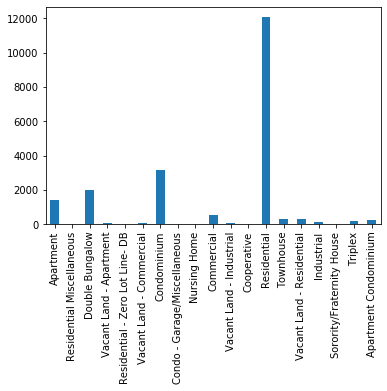

In [42]:
property_sales.prop_type.value_counts(sort=False).plot.bar()

Although the magnitude of teh residential properties sold is highly disproportionate to the rest of the property types on the market we will preserve this feauture as it seems important. 

##### `prefix_direction`

In [43]:
property_sales[property_sales.prefix_direction.isna()].shape

(0, 24)

In [44]:
len(property_sales.prefix_direction.unique())

2

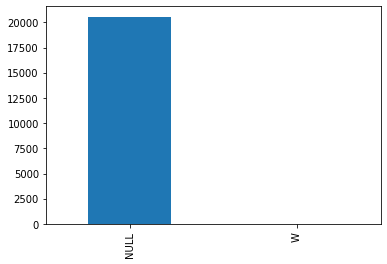

In [45]:
property_sales.prefix_direction.value_counts(sort=False).plot.bar()

Apparently, most of the values for this feature are missing, so it will not be taken into account for our analysis.

##### `street_type`

In [46]:
property_sales[property_sales.street_type.isna()].shape

(0, 24)

In [47]:
len(property_sales.street_type.unique())

13

In [48]:
property_sales.street_type.unique()

array(['ST', 'AVE', 'CT', 'PL', 'BLVD', 'RD', 'PKWY', 'DR', 'LN', 'TERR',
       'NULL', 'CIR', 'CV'], dtype=object)

In [49]:
property_sales[property_sales['street_type'] == 'NULL'].shape 

(72, 24)

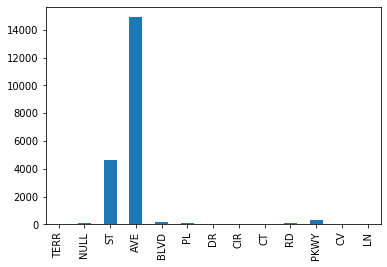

In [50]:
property_sales.street_type.value_counts(sort=False).plot.bar()

Although the `NULL` values are negligibly small, after the initial iterations of our analysis we came to the conclusion that the impact of this feature to the outcome of our clustering is minimal, therefore we are removing it for further use.

##### `suffix_direction`

In [51]:
property_sales.suffix_direction.unique()

array(['S', 'NE', 'N', 'SE', 'E', 'W', 'NULL'], dtype=object)

In [52]:
property_sales[property_sales['suffix_direction'] == 'NULL'].shape

(5334, 24)

In [53]:
len(property_sales[property_sales['suffix_direction'] == 'NULL'])/len(property_sales) # 5% of the data is NULL

0.2595620437956204

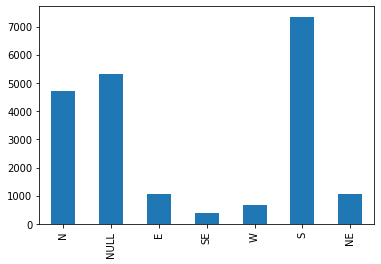

In [54]:
property_sales.suffix_direction.value_counts(sort=False).plot.bar()

The missing values for this categorisation variable are `26%`, which means that if we exclude these samples from the dataset, it would have too high (negative) impact on the clustering (as there would not be enough number of data samples but the number of features would be too high, i.e. due to the "curse of dimensionality" we could introduce too much noise in the output model). 

Also, on a later step probably the missing `suffix_direction` values could be deduced/populated based on the geo-related information. Also due to time restriction, this will be left as a future work. 

In the meantime, this column will be removed from the modeling process.

#### Processing Sale Date Related Features

##### `sale_date` and `sale_date_2`

It seems that `sale_date` and `sale_date_2` have identical values, hence we dismiss the second copy (`sale_date_2`) of the data:

In [55]:
property_sales[property_sales['sale_date'] != property_sales['sale_date_2']].shape

(0, 24)

We would like to check whether converting `sale_date` to a `datetime` type would be of any use for our analysis:

In [56]:
property_sales['sale_date'] = property_sales['sale_date'].apply(pd.to_datetime)

##### Exploring `year`, `month`, `day` features 

Creating three new properties from the date - `year`, `month` and `day`:

In [57]:
property_sales['year'] = property_sales.sale_date.dt.year

In [58]:
property_sales.year.unique()

array([2004, 2005, 2002, 2003])

(array([4476., 4795., 5310., 5969.]),
 array([2002.  , 2002.75, 2003.5 , 2004.25, 2005.  ]),
 <a list of 4 Patch objects>)

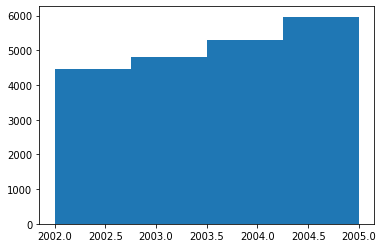

In [59]:
plt.hist(property_sales.year, bins = 4)

It does not look like the sales have major changes throughout the years, hence we would not create a new feature for year.

Creating a `month` feature for potential use:

In [60]:
property_sales['month'] = property_sales['sale_date'].dt.month

In [61]:
property_sales.month.unique()

array([12,  9,  3,  5, 10,  6,  1,  8, 11,  4,  7,  2])

(array([1245., 1208., 1558., 1652., 1984., 2023., 1889., 2143., 1960.,
        1787., 1587., 1514.]),
 array([ 1.        ,  1.91666667,  2.83333333,  3.75      ,  4.66666667,
         5.58333333,  6.5       ,  7.41666667,  8.33333333,  9.25      ,
        10.16666667, 11.08333333, 12.        ]),
 <a list of 12 Patch objects>)

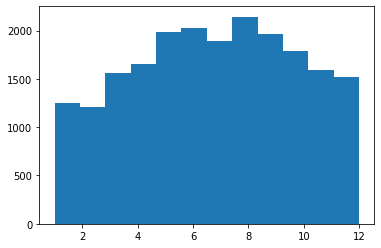

In [62]:
plt.hist(property_sales.month, bins = 12)

Creating a `day` feature for potential use during the clustering:

In [63]:
property_sales['day'] = property_sales['sale_date'].dt.day

(array([ 761.,  451.,  479.,  416.,  454.,  401.,  442.,  451.,  410.,
         534.,  405.,  512.,  484.,  614., 1040.,  613.,  596.,  601.,
         534.,  587.,  624.,  704.,  659.,  644.,  828.,  821.,  953.,
        1198., 1179., 1389.,  766.]),
 array([ 1.        ,  1.96774194,  2.93548387,  3.90322581,  4.87096774,
         5.83870968,  6.80645161,  7.77419355,  8.74193548,  9.70967742,
        10.67741935, 11.64516129, 12.61290323, 13.58064516, 14.5483871 ,
        15.51612903, 16.48387097, 17.4516129 , 18.41935484, 19.38709677,
        20.35483871, 21.32258065, 22.29032258, 23.25806452, 24.22580645,
        25.19354839, 26.16129032, 27.12903226, 28.09677419, 29.06451613,
        30.03225806, 31.        ]),
 <a list of 31 Patch objects>)

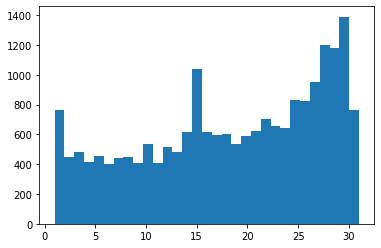

In [64]:
plt.hist(property_sales.day, bins=31)

It seems that `day` and `month` might be useful for the clustering, although there is high probability that they will introduce too many indicator variables, which might have an impact on the precision of the clustering (due to insufficient sample data). At first, we would exclude these features from the clustering.

It does not look like we will need `sale_date` and `year` properties, so we are going to remove them from the feature set as well.

#### Processing Sale Participants Related Features

It seems that the property market jargon in USA the seller of the property is called grantor and the person who pruchases the property - grantee.

##### `grantee`

In [65]:
property_sales.grantee.unique()

array(['Larry J Schmidt', 'Christian J Girtz', 'John P Breese', ...,
       'Eric A Thoerner', 'Daniel Whipp', 'Harald F Markley'],
      dtype=object)

In [66]:
property_sales[property_sales.grantee.isna()].shape

(0, 27)

In [67]:
len(property_sales.grantee.unique())/len(property_sales)

0.9151824817518248

It seems that `91%` of the grantees are different people, which means that the values in that column are virtually unique, hence we will exclude this column from the clustering analysis.

##### `grantor`

In [68]:
property_sales.grantor.unique()

array(['John M Parkman', 'Neil Kynnersley', 'Joan A Leong', ...,
       'Sara E Sternberger', 'Linda O Bergum', 'Philip B Mortenson'],
      dtype=object)

In [69]:
property_sales[property_sales.grantor.isna()].shape

(0, 27)

In [70]:
len(property_sales.grantor.unique())/len(property_sales)

0.8002433090024331

Similarly to the grantees, grantors seem to be `84%` unique, hence we will exclude this feature from the clustering as well.

#### Processing Sale Price Features

##### `gross_sale_price`

In [71]:
property_sales.gross_sale_price.unique()

array([163200., 179900., 260000., ..., 208120., 364900., 552000.])

In [72]:
property_sales[property_sales.gross_sale_price.isna()].shape

(0, 27)

In [73]:
min(property_sales.gross_sale_price)

0.0

In [74]:
property_sales.gross_sale_price = property_sales.gross_sale_price.fillna(-1)

In [75]:
len(property_sales[property_sales.gross_sale_price == 0].gross_sale_price)/len(property_sales)

0.00043795620437956203

In [76]:
property_sales.gross_sale_price.unique()

array([163200., 179900., 260000., ..., 208120., 364900., 552000.])

In [77]:
property_sales.gross_sale_price.value_counts(sort=True) #.plot.bar()

175000.0    189
200000.0    180
150000.0    169
165000.0    168
180000.0    163
           ... 
321450.0      1
185300.0      1
117225.0      1
415929.0      1
218649.0      1
Name: gross_sale_price, Length: 5178, dtype: int64

The number of unavailable values for `gross_sale_price` is negligible (~`0.5%`), therefore filled in the missing values with `-1` in order to rectify the validity of the values in the column. It is true that we introduce bias in that way, but for now we consider it acceptable.

##### `adjusted_sale_price`

In [78]:
property_sales.adjusted_sale_price.unique()

array([163200., 179900., 260000., ..., 208120., 364900., 537303.])

In [79]:
property_sales[property_sales.adjusted_sale_price.isna()].shape

(2, 27)

In [80]:
len(property_sales[property_sales.adjusted_sale_price < 0])

9

In [81]:
property_sales.adjusted_sale_price = property_sales.adjusted_sale_price.fillna(-1)

In [82]:
property_sales.adjusted_sale_price.value_counts(sort=False)#.plot.bar()

 0.0         10
 131072.0     1
-1.0          2
 1.0          2
 180225.0     1
             ..
 983000.0     1
 98300.0      1
 294900.0     6
 409594.0     1
 94207.0      1
Name: adjusted_sale_price, Length: 6059, dtype: int64

In [83]:
property_sales[property_sales.adjusted_sale_price < 0].head()

,object_id,crv,pin,sale_date,in_rto_study,neighborhood,ward,prop_type,address,house_number,house_number_2,prefix_direction,street_name,street_type,suffix_direction,grantee,grantor,adjusted_sale_price,gross_sale_price,sale_date_2,downpayment,x,y,geometry,year,month,day
1430,6431,882975.0,"""2202824120129""",2004-12-29,Yes,WINDOM,11,Residential,5520 1ST AVE S,5520,NULL,NULL,1ST,AVE,S,Aaron J Harkins,Wendy M Brekken,-4900.0,270000.0,2004-12-29T00:00:00,NULL,527515.075938,140708.623010,POINT (-93.27715160428389 44.9027108863392),2004,12,29
5345,14346,858080.0,"""602823240193""",2004-05-14,No,LONGFELLOW,2,Residential,3300 36TH AVE S,3300,NULL,NULL,36TH,AVE,S,Chicago Investment Group Corporation,Shigeo Hotta,-15100.0,45000.0,2004-05-14T00:00:00,900,542098.359766,155446.645034,POINT (-93.2207601518804 44.94306520980577),2004,5,14
10076,1077,894638.0,"""202824430124""",2005-06-10,Yes,POWDERHORN PARK,8,Residential,3733 12TH AVE S,3733,NULL,NULL,12TH,AVE,S,Adam C Thorne,Susan M Schmid,-4000.0,208700.0,2005-06-10T00:00:00,16870,532704.134265,152379.565737,POINT (-93.25705666097673 44.93469935551516),2005,6,10
11047,15048,882280.0,"""102824340010""",2004-12-31,Yes,STANDISH,12,Residential,2318 38TH ST E,2318,NULL,NULL,38TH,ST,E,Dena M Sanford,Ryvonne M Dennis,-3900.0,138000.0,2004-12-31T00:00:00,NULL,537662.758305,152263.296399,POINT (-93.23791134691828 44.93435767124459),2004,12,31
13012,12013,885393.0,"""1202824110121""",2004-12-27,No,STANDISH,12,Residential,3824 30TH AVE S,3824,NULL,NULL,30TH,AVE,S,William S Mcelligott,Western United Life Assurance Co C / O Ocwen F...,-102000.0,48000.0,2004-12-27T00:00:00,NULL,539728.409111,151875.106682,POINT (-93.22993839137166 44.93328257189802),2004,12,27


The number of unavailable values for `adjusted_sale_price` is negligible (~`0.01%`), therefore filled in the missing values with `-1` in order to rectify the validity of the values in the column but there are a few values which are negative, which might mean that we cannot rely on this feature for the clustering phase, therefore we will remove this feature from the analysis.

##### `downpayment`

In [84]:
property_sales.downpayment.unique()

array(['32650', '5400', '260000', ..., '26600', '545000', '52250'],
      dtype=object)

In [85]:
len(property_sales[property_sales.downpayment == 'NULL'])/len(property_sales) # 5% of the data is NULL

0.6149391727493917

As `61%` of the `downpayment` values are missing, we remove this feature.

#### Processing Geography Related Features

##### `x` and `y`

As per dataset features description:

> _X ... and... Y ... coordinates are expressed in the NAD 83 Hennepin County HARN coordinate system (WKID: 103734)_

we are not interested at the moment in these features, so we are going to remove them.

##### `geometry`, `lat` and `lon`

In [86]:
property_sales[property_sales.geometry.isna()].shape

(0, 27)

As `geometry` is of type `Point`, it does seem to be an unhashable type, which would become an obstacle later on during the creation of indicator variables (dummies). That is why we create two numeric columns `lat` and `lon` respectively, which would represent lattitude and longitude:

In [87]:
property_sales['lat'] = property_sales.geometry.x

In [88]:
property_sales['lon'] = property_sales.geometry.y

###### Properties Plotted on a Geo Map

We do a quick check whether the usage of the new latitude and longitude features are useful and whether we could gain some insights from plotting the properties on an actual geographical map

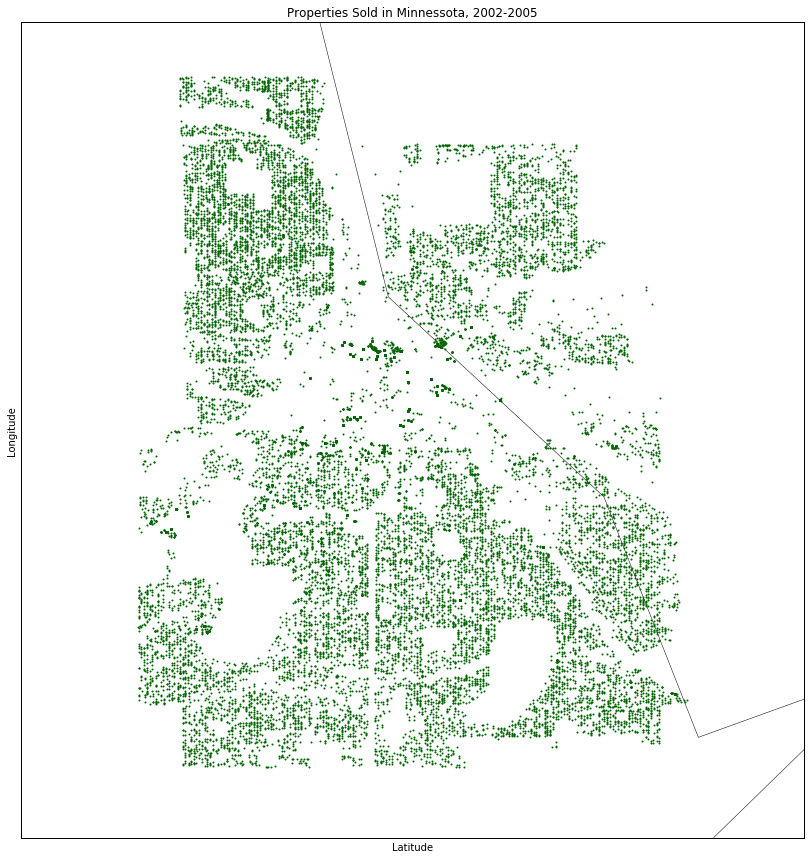

In [89]:
import warnings
warnings.filterwarnings('ignore')

figure = plt.figure(figsize=(15,15))
current_axis = figure.add_subplot(111)

map = Basemap(llcrnrlon=-93.356022, llcrnrlat=44.874466, urcrnrlon=-93.174347, urcrnrlat=45.063683, \
              resolution='i', lat_0 = 46.392410, lon_0 = -94.636230, width=100, height=200)
map.fillcontinents(color = "white", lake_color = "#7777ff", ax = current_axis)

earth_x, earth_y = map(property_sales.lat.tolist(), property_sales.lon.tolist())

map.scatter(earth_x, earth_y, color="darkgreen", s = 1, zorder=10)
map.drawmapboundary(fill_color = "#7777ff")
map.drawstates()
map.drawcountries()
map.drawrivers()

plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Properties Sold in Minnessota, 2002-2005")

plt.show()

At first sight, visually screening the property sales plotted on a geo-map, we cannot obtain any insight on whether geo-defined clustering of the data is in place or not.

### Removing Redundant Features 

In [90]:
property_sales.shape

(20550, 29)

Following the results from the initial data analysis, we are to remove the features which do not appear useful for our clustering analysis:
* `object_id`
* `crv`
* `pin`
* `address`
* `house_number`
* `house_number_2`
* `prefix_direction`
* `street_name`
* `street_type`
* `suffix_direction`
* `sale_date_2`
* `sale_date`
* `year`
* `grantee`
* `grantor`
* `adjusted_sale_price`
* `downpayment`
* `x`
* `y`
* `geometry`

In [91]:
columns_for_removal = ['object_id', 'crv', 'pin', 'address', 'house_number', 'house_number_2', 'prefix_direction', \
                       'street_name', 'street_type', 'suffix_direction', 'sale_date_2', 'sale_date', 'year', 'month', \
                       'day', 'grantee', 'grantor', 'downpayment', 'x', 'y', 'geometry', 'adjusted_sale_price']

In [92]:
property_sales_data = property_sales.drop(columns=columns_for_removal, axis=1)

The set of initial features we end up with for clustering is as follows:

In [93]:
property_sales_data.head()

,in_rto_study,neighborhood,ward,prop_type,gross_sale_price,lat,lon
0,Yes,DOWNTOWN WEST,3,Condominium,163200.0,-93.266497,44.982613
3,Yes,DOWNTOWN WEST,3,Condominium,179900.0,-93.266497,44.982613
4,Yes,DOWNTOWN WEST,3,Condominium,260000.0,-93.266497,44.982613
5,No,DOWNTOWN WEST,3,Commercial,16500.0,-93.266497,44.982613
6,Yes,DOWNTOWN WEST,3,Condominium,230000.0,-93.266497,44.982613


In [94]:
property_sales_data.shape

(20550, 7)

### Creating Indicator Variables/Features (Dummies)

As some of the features are with category nature, e.g. `prop_type`, `ward`, `neighborhood`, based on their values we need to create indicator variables, so that we have all our features be of numerical types, thus easy to process later on.

In [95]:
property_sales_data_dummies = pd.get_dummies(property_sales_data)

In [96]:
property_sales_data_dummies.shape

(20550, 112)

In [97]:
property_sales_data_dummies.describe().T

,count,mean,std,min,25%,50%,75%,max
ward,20550.0,7.069586,3.907593e+00,1.000000,4.000000,7.000000,11.000000,1.300000e+01
gross_sale_price,20550.0,318302.043406,2.787592e+06,0.000000,150362.500000,199900.000000,275000.000000,2.245000e+08
lat,20550.0,-93.271668,3.138176e-02,-93.328812,-93.297212,-93.273372,-93.248958,-9.320141e+01
lon,20550.0,44.963505,4.234711e-02,44.890816,44.927711,44.960364,44.999204,4.505106e+01
in_rto_study_No,20550.0,0.296545,4.567452e-01,0.000000,0.000000,0.000000,1.000000,1.000000e+00
...,...,...,...,...,...,...,...,...
prop_type_Triplex,20550.0,0.008856,9.369332e-02,0.000000,0.000000,0.000000,0.000000,1.000000e+00
prop_type_Vacant Land - Apartment,20550.0,0.003358,5.784940e-02,0.000000,0.000000,0.000000,0.000000,1.000000e+00
prop_type_Vacant Land - Commercial,20550.0,0.004185,6.455698e-02,0.000000,0.000000,0.000000,0.000000,1.000000e+00
prop_type_Vacant Land - Industrial,20550.0,0.001995,4.462343e-02,0.000000,0.000000,0.000000,0.000000,1.000000e+00


We observe tenfold increase of the number of features, but the number is not too high. Also during the PCA step of the data pre-processing will help us discard the influence of the insignificant features for our clustering.

### Scaling Features

As the values for the various feature values vary highly, we would like to put them in the same range so that our clustering analysis does not get skewed by the various scales of the feature. For the purpose we will use `MinMaxScaler` which will place all values in the `[0,1]` range.

In [98]:
scaler = MinMaxScaler()

In [99]:
scaler.fit(property_sales_data_dummies)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [100]:
property_sales_data_dummies_scaled = scaler.transform(property_sales_data_dummies)

### Principal Component Analysis (PCA)

Having too many features (i.e. high dimensionality), we cannot distinguish which are important ones for our analysis and which not, that is why we use Principal Component Analysis approach for linear dimensionality reduction to project it to a lower dimensional space.

In [101]:
pca = PCA().fit(property_sales_data_dummies_scaled)

In [102]:
property_sales_data_dummies_scaled_transformed = pca.transform(property_sales_data_dummies_scaled)

We need to look into which of the variance ratios are highest in order to find new attributes, which could represent the data in the new dimensional space.

In [103]:
pca.explained_variance_ratio_

array([2.27967447e-01, 1.04895007e-01, 7.51456606e-02, 5.61264558e-02,
       3.52280761e-02, 3.23316840e-02, 1.52494145e-02, 1.42942816e-02,
       1.16726192e-02, 1.14835455e-02, 1.08570142e-02, 1.03485196e-02,
       1.02254468e-02, 9.54146966e-03, 9.27293581e-03, 9.03280563e-03,
       8.89131313e-03, 8.79766441e-03, 8.37075972e-03, 8.28265838e-03,
       8.14225944e-03, 7.74784021e-03, 7.63954735e-03, 7.51904786e-03,
       7.38044897e-03, 7.16129965e-03, 7.00139870e-03, 6.91896547e-03,
       6.71993879e-03, 6.65690711e-03, 6.50563644e-03, 6.33823910e-03,
       6.23462036e-03, 6.12771686e-03, 6.03221207e-03, 5.93988864e-03,
       5.84634748e-03, 5.67041739e-03, 5.60645297e-03, 5.50657233e-03,
       5.47942232e-03, 5.37040400e-03, 5.31409581e-03, 5.29903214e-03,
       5.18900160e-03, 5.04658548e-03, 5.01080714e-03, 4.98355528e-03,
       4.91421520e-03, 4.88462474e-03, 4.78216554e-03, 4.76846784e-03,
       4.71537458e-03, 4.67415371e-03, 4.59677690e-03, 4.58532113e-03,
      

We observe that the first two ratios are highest, that is why we are going to limit our reduced features to them only. 

Please note that both options with smaller and higher number of PCA-ed features were explored, but the optimal results are achieved with only two of them. That is why we are reducing the PCA-transformed data set to just two parameters:

In [104]:
property_sales_data_dummies_scaled_transformed_reduced = property_sales_data_dummies_scaled_transformed[:, :2]

In [105]:
property_sales_data_dummies_scaled_transformed_reduced.shape

(20550, 2)

This is the dataset which we would use for clustering.

## Finding Optimal Number of Clusters

In the following sections we will try to cluster the data using several clustering algorithms in order to find the most optimal clustering, thus finding the most optimal internal structure of the dataset. The algorithms used are the following: `KMeans++ Clustering`, `Agglomerative Clustering` and `Density Based Clustering Analysis (DBSCAN)`.

Before jumping to the actual analysis we will define some auxilliary functions which will help us visualise and work with the clustered data

### Auxilliary Functions for Cluster and Map Drawing

In [106]:
def plot_clusters(data, cluster_ids, title):
    """Plots clustered data in 2D format. 

    Parameters:
    data (int): 2D data which will be scattered
    cluster_ids: an array of cluster ids
    title: Plot title
   """
    plt.figure(figsize = (12,10))
    plt.scatter(data[:, 0], data[:, 1], c = cluster_ids)
    plt.title(title)
    plt.show()

In [107]:
# def plot_category_by_geo_location(data, clusters, category):
    
#     indices = np.where(clusters == category)
    
#     samples = data.iloc[indices]
#     categories = clusters[indices]
    
#     plot_title = "KMeans++ Clustering of Sold Properties: Category" + str(category)
#     plot_clustered_properties_by_geo_location(samples, categories, plot_title)

In [108]:
# def plot_clustered_data(data, clusters, x, y):
# #     samples = samples.drop(columns = samples.columns, axis=1)
#     samples = data
#     samples['category'] = clusters
#     samples

#     sns.lmplot(x, y, data=samples, hue="category", fit_reg = False, col = 'category', col_wrap=2)

In [109]:
# Based on: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def plot_kmeans_cluster_silhouette_profiles(data, clusters, clusterer):

    X = data
    cluster_labels = clusters
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    n_clusters = len(centers)

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])



    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')


    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

In [110]:
def plot_dendrogram(agglomerative_linkage, title):
    plt.figure(figsize = (12,10))
    dendrogram(agglomerative_linkage, leaf_rotation=0, orientation='right')
    
    ax = plt.gca()
    bounds = ax.get_ybound()
    ax.plot([1.1,1.1],bounds,'--', c='k', )
    plt.title(title)
    plt.show()

In [111]:
def create_dbscan_diagram_title(dbscan_cluster_number, dbscan_eps, dbscan_min_samples):
    return "Density Based (DBSCAN) Clusters: Clusters {}, for eps={}, min_samples={}"\
                .format(dbscan_cluster_number, dbscan_eps, dbscan_min_samples)

### Finding Right Number of Clusters 

In the next sub-sections we will use several approaches to find the most optimal number of clusters for the provided dataset.

#### Plotting Clustered Data

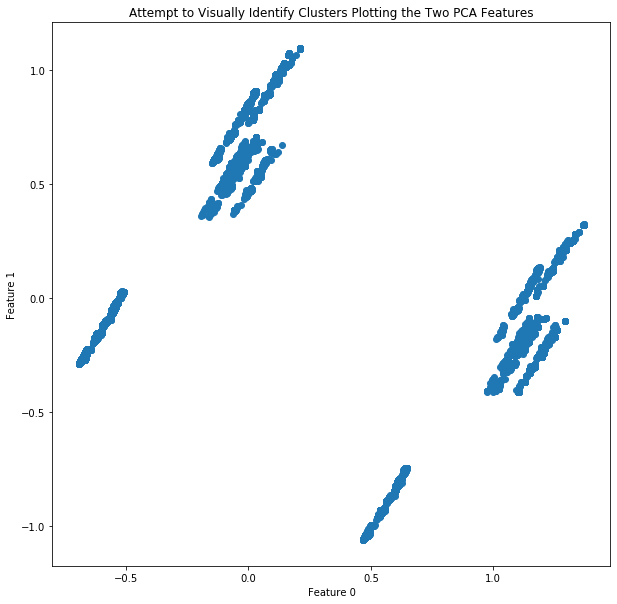

In [112]:
plt.figure(figsize = (10,10))
plt.scatter(property_sales_data_dummies_scaled_transformed_reduced[:, 0], 
            property_sales_data_dummies_scaled_transformed_reduced[:, 1])
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.title("Attempt to Visually Identify Clusters Plotting the Two PCA Features")
plt.show()

Although we could visually identify `4` well separated clusters, we will need to use more quantative approaches to prove that this is the most optimal number of clusters which exist for the properties sales dataset.

#### KMeans++ Clustering: Elbow Method

KMeans++ clustering algorithm expects number of clusters to be provided upfront. 

In order to select the most optimal number of clusters which properties sales dataset could be organised into, we will first calculate cluster intertias for the various configuration in terms of numbers of clusters and then apply the Elbow Method to define the most optimal clusters configuration (if the intertias/elbow function is good enough to alow it).

In [113]:
inertias = []
for i in range(1, 11):
    km = KMeans(n_clusters = i)
    km.fit(property_sales_data_dummies_scaled_transformed_reduced)
    inertias.append(km.inertia_)

The **Elbow Method** is is a heuristic method of interpretation and validation the consistency within clusters analysis which is designed to help finding the optimal number of clusters to which a dataset could be split.

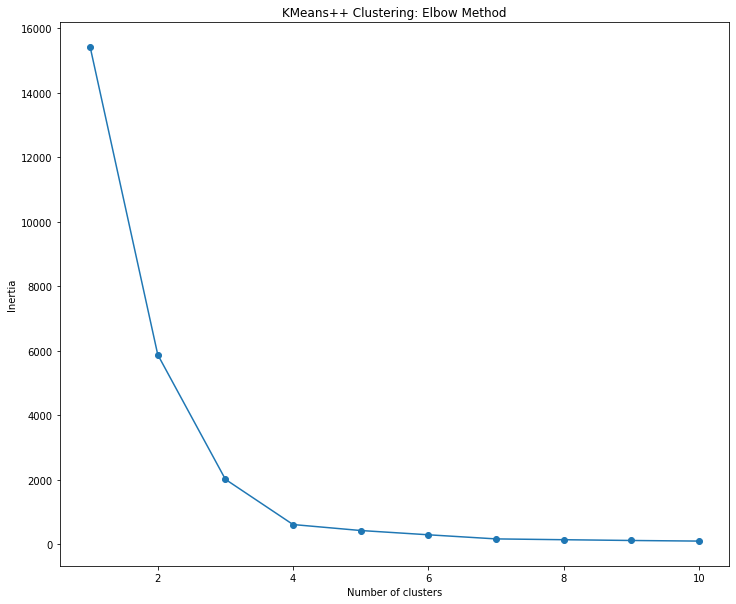

In [114]:
plt.figure(figsize = (12,10))
plt.plot(range(1, 11), inertias, marker = "o")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("KMeans++ Clustering: Elbow Method")
plt.show()

As we could see the shape of the graph resembles elbow, which would mean that our data is well separated and allows for this method to be used. 

We could identify **`4`** as **the optimal number of clusters** as on the left hand side of the "point `4`" the inertias function decreases quicker than on the right side of the point, which means that increasing the number of clusters to more than 4, we would unnecessarily break the data to smaller clusters, without actually gaining any benefit. In fact, the distances between the clusters will not be that big and we ultimately will create unnecessarily high number of cluster.


As this method is often ambiguous and not very reliable, despite its good indication in our case, to confirm/disprove its output we will apply a couple of more approaches for determining the optimal number of clusters for our dataset, namely the Silhouette method for KMeans++ Clustering and Dendrogram Diagram for Agglomerative Clustering. 

#### KMeans++ Clustering: Cluster Silhouette Profies Method 

Another approach which could be used for finding the optimal number of clusters for a given dataset using the KMeans++ Clustering approach is the Silhouette Profiles, where such number of clusters is sought for which the distances of the points in the clusters to the centroid of the cluster are fairly equal, as well as the size of the clusters is ideally the same.

We will analyse the silhouette profiles of the various number of clusters in order to prove that `4` seems to be the best choice.

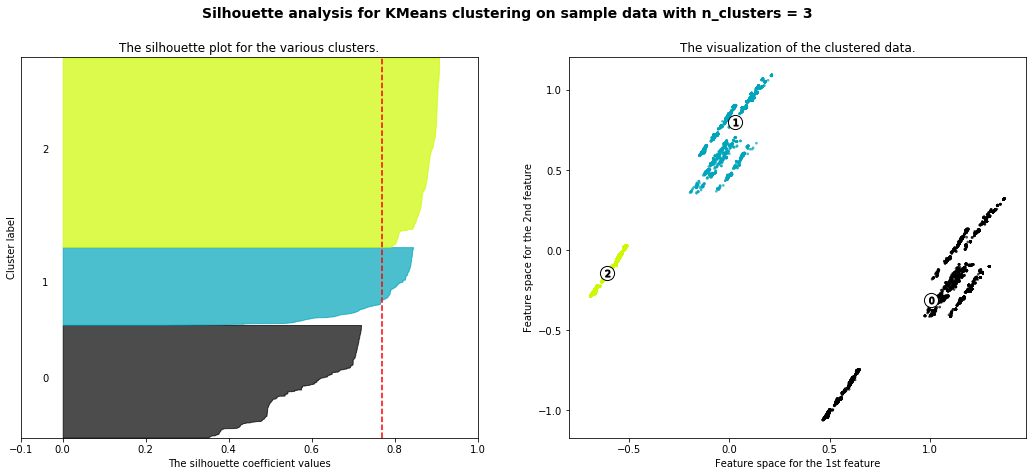

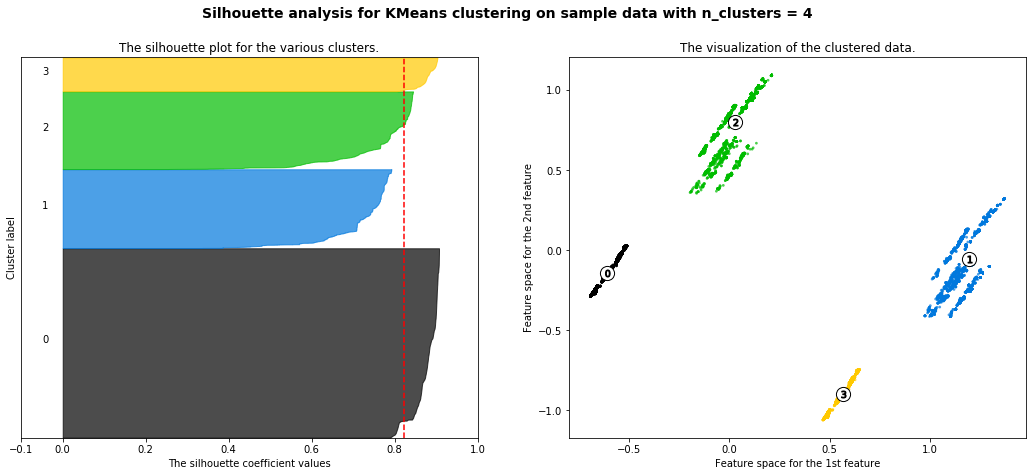

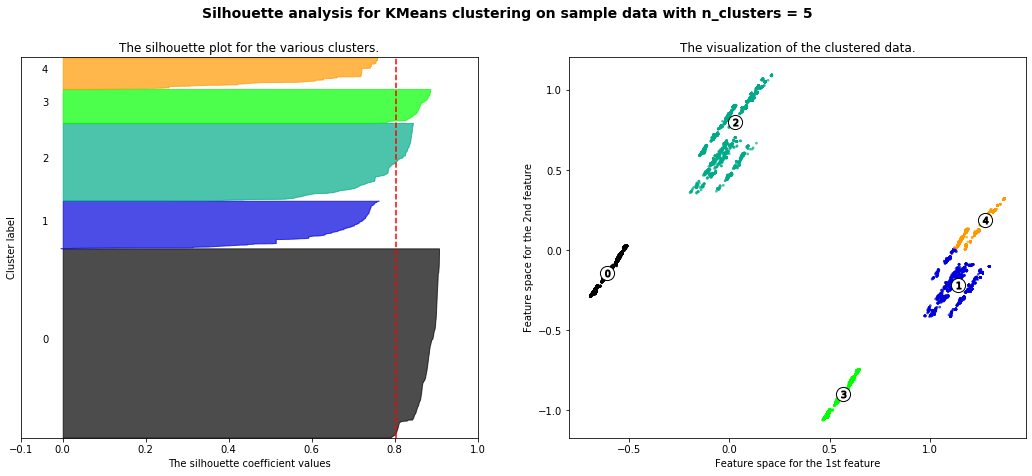

In [115]:
for number_of_clusters in [3, 4, 5]:
    kmeans_clusterer = KMeans(n_clusters = number_of_clusters)
    kmeans_clusterer.fit(property_sales_data_dummies_scaled_transformed_reduced)
    kmeans_clusters = kmeans_clusterer.predict(property_sales_data_dummies_scaled_transformed_reduced)
    plot_kmeans_cluster_silhouette_profiles(property_sales_data_dummies_scaled_transformed_reduced, \
                                        kmeans_clusters, kmeans_clusterer)

We could see that the most optimal data distribution of the data in clusters is when the number of clusters is `4`. In the case of `3` and `5` the clusters are not well shaped in the sense that there are points in the cluster which are closer to the centroids than others. In the case of `4` clusters, although the size of the clusters is not the same, the centroids are in a relatively equal distance from each point in the cluster.

We should note that KMeans++ works well but only if the data is well organised in clearly separated clusters. In our dataset it seems that we have well defined clusters which do not overlap which would mean that we could be fairly confident in using KMeans++ as a clustering approach.

#### Agglomerative Clustering: Dendrogram Diagram Method

Another way of assessing the most optimal number of clusters for a dataset is to use the agglomerative clustering approach and more specifically to use its **dendrogram** which similarly to the Elbow Method is based on the interias of the clusters. This approach is used to find out what is the number of clusters based on the larger distances between the points on the dendrogram.

We will use the default implementation of agglomerative linkage (with two clusters) provided by `scipy` to plot the dendrogram:

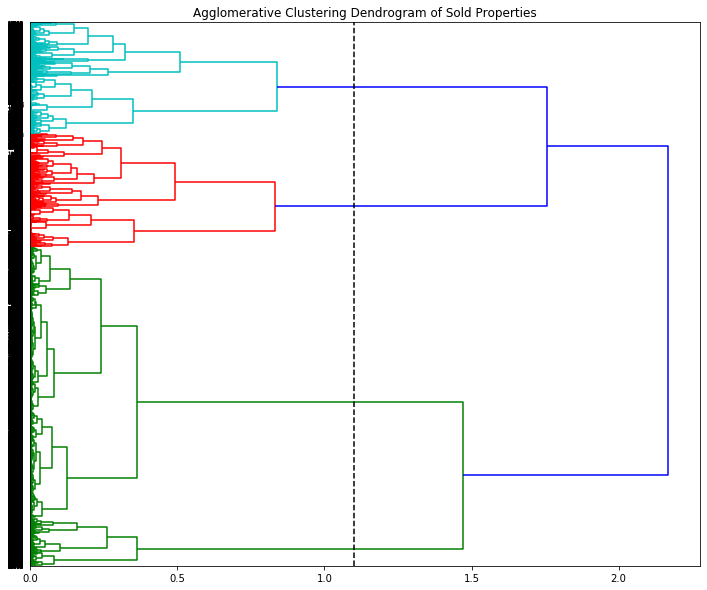

In [116]:
default_agglomerative_linkage = linkage(property_sales_data_dummies_scaled_transformed_reduced, \
                                    method = "complete", metric = "euclidean")

plot_dendrogram(default_agglomerative_linkage, "Agglomerative Clustering Dendrogram of Sold Properties")

Another approach of drawing the dendrogram of the property sales dataset is to use `seaborn` out-of-the-box functionality:

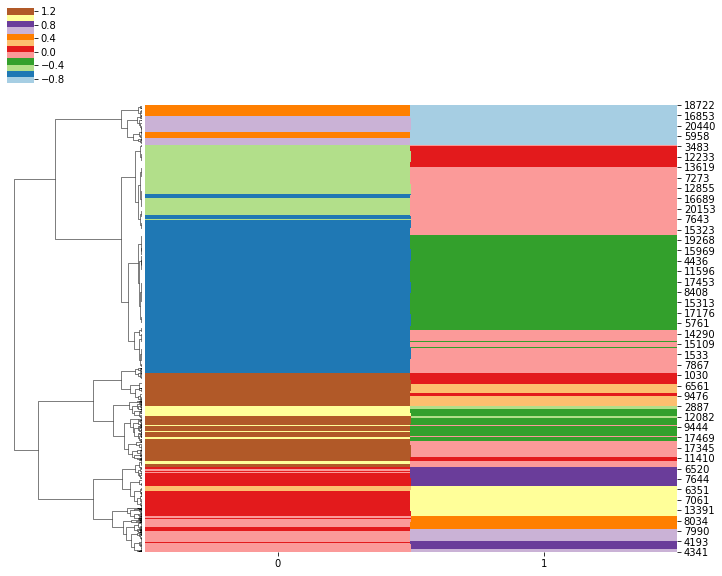

In [117]:
g = sns.clustermap(property_sales_data_dummies_scaled_transformed_reduced, \
                   method="complete", col_cluster=False,\
                   cmap="Paired", robust = True, figsize=(12, 10))

In both cases we could see that the longest distances between clusters are achieved for cluster distances between `0.8` and `1.5`. If we draw a line perpendicular to the clustering lines, the number of intersection points gives us the optimal number of clusters the dataset could be split when using agglomerative clustering, which is again `4`.

As shortly would be shown, the dataset has well shaped clusters, so all clustering algorithms used identify the same clusters.

#### DBSAN Clustering: Visual Method

Unfortunately Density Based Spatial Clustering for Applications with Noise (DBSCAN) does not have any specific method for finding the number of clusters, so we will generate several clustering options changing the radius $\epsilon$ of the vicinity and the number of noise points in order to visually identify the best number of clusters.

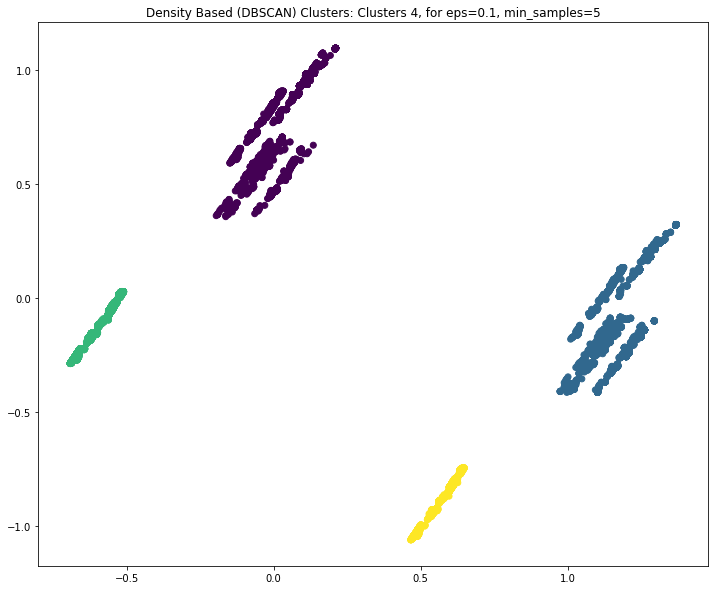

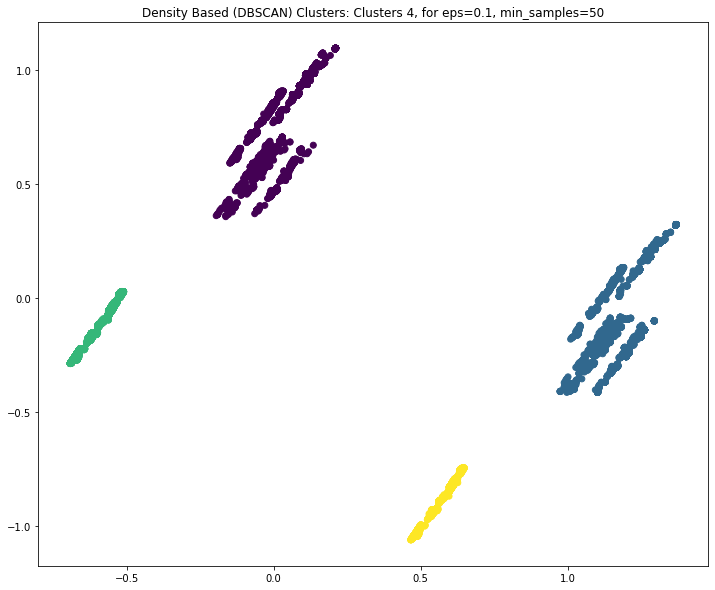

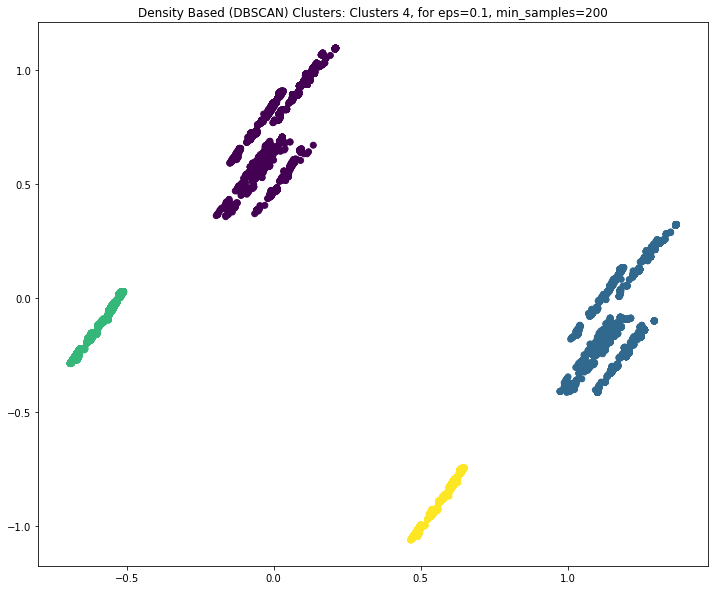

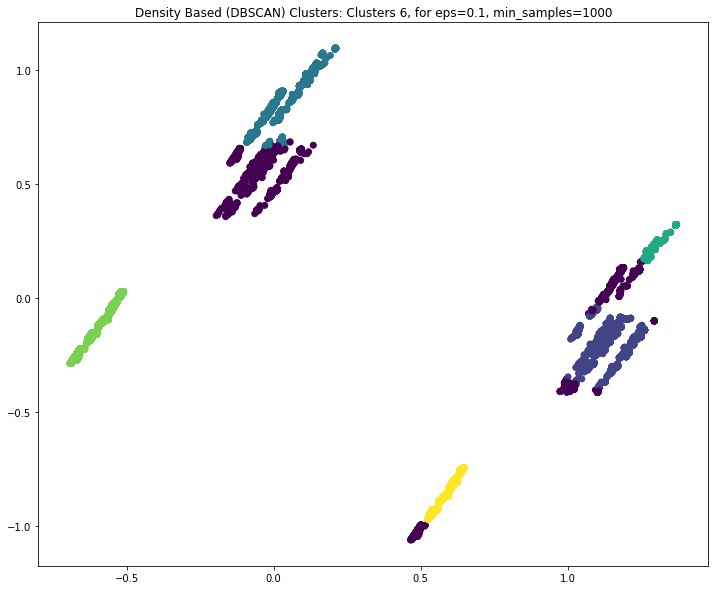

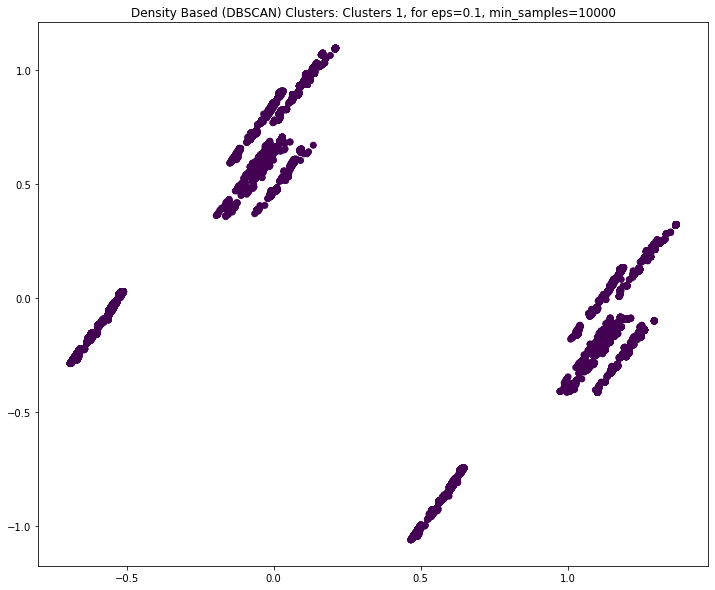

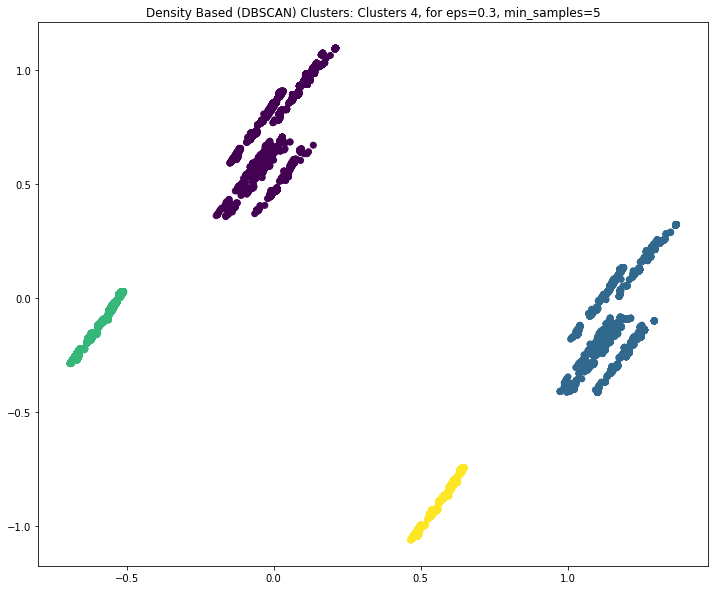

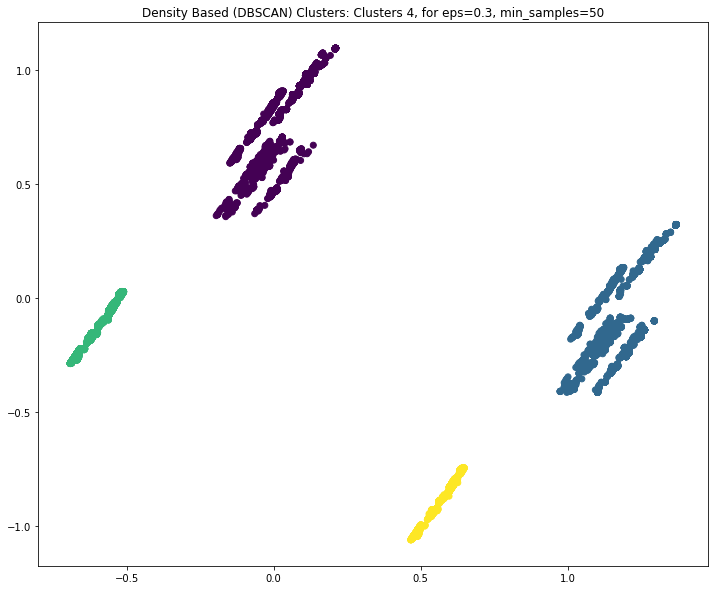

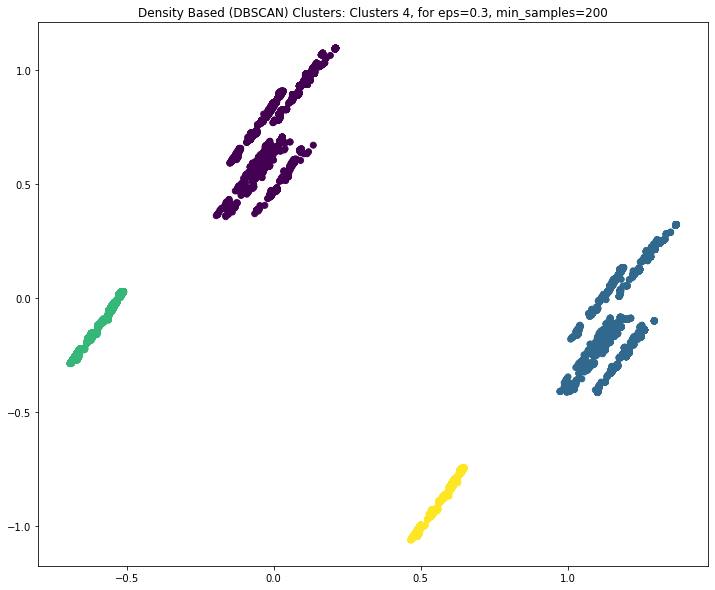

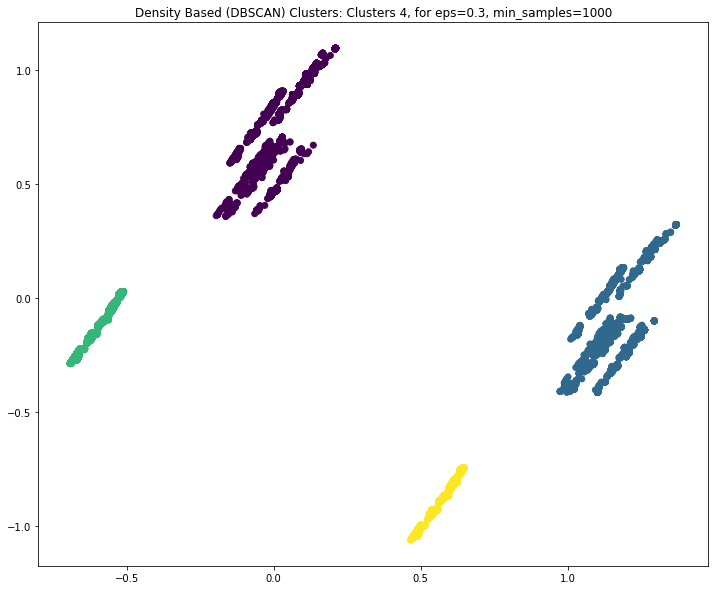

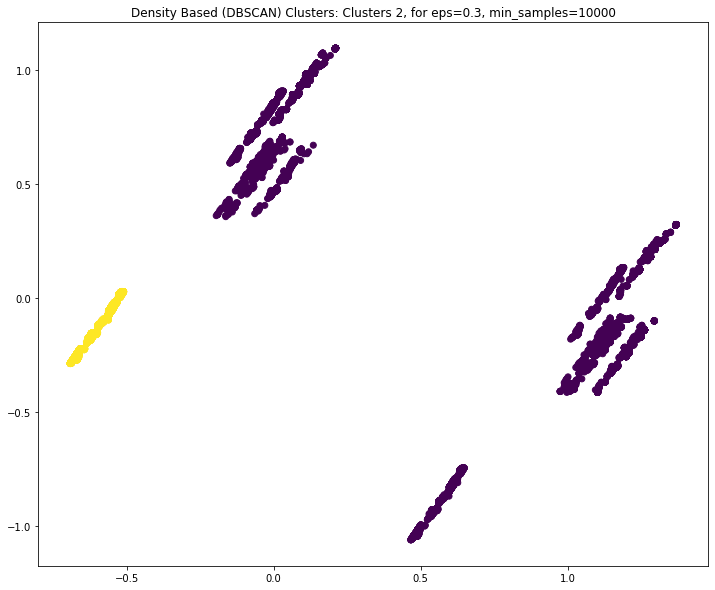

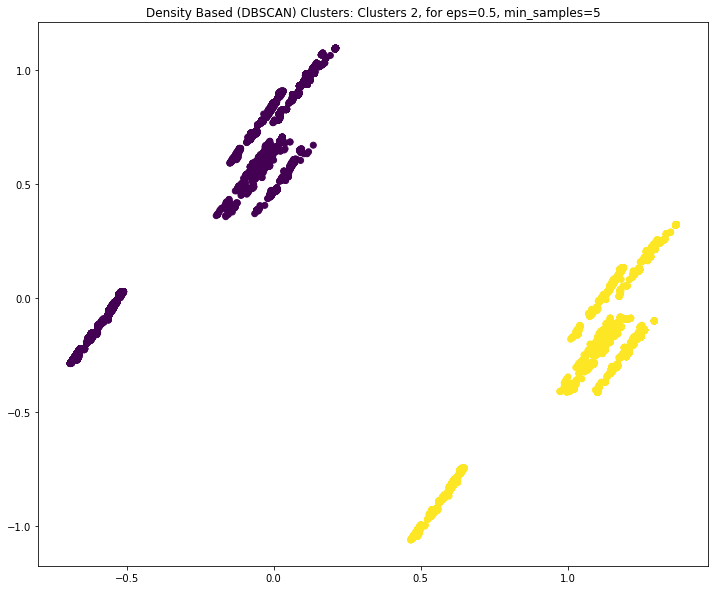

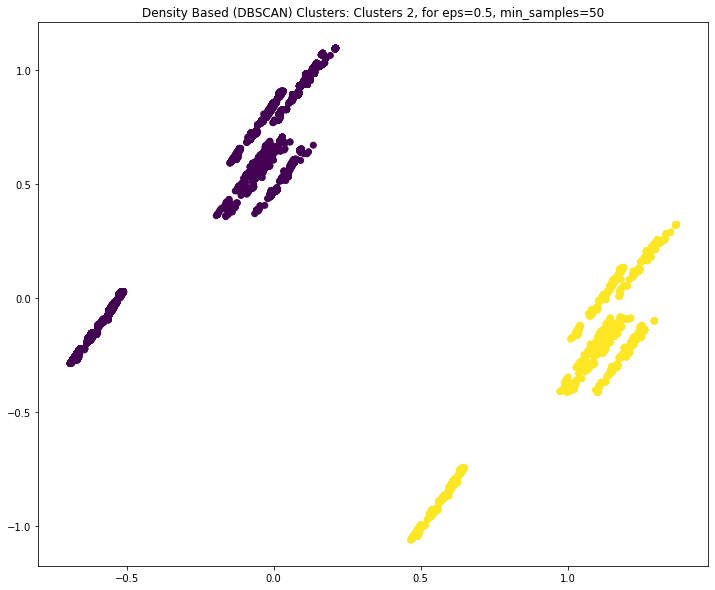

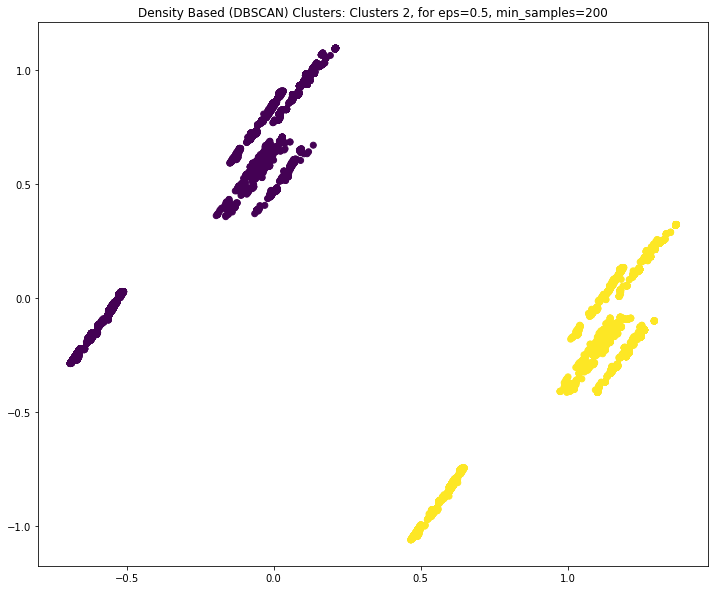

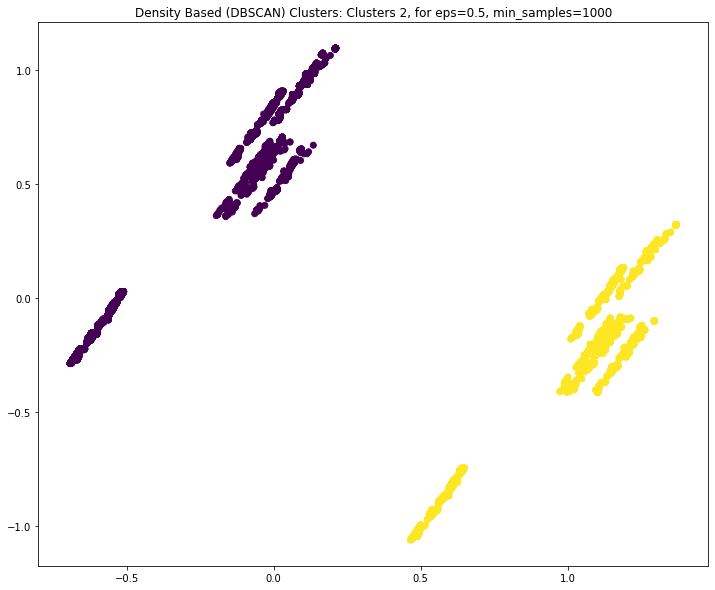

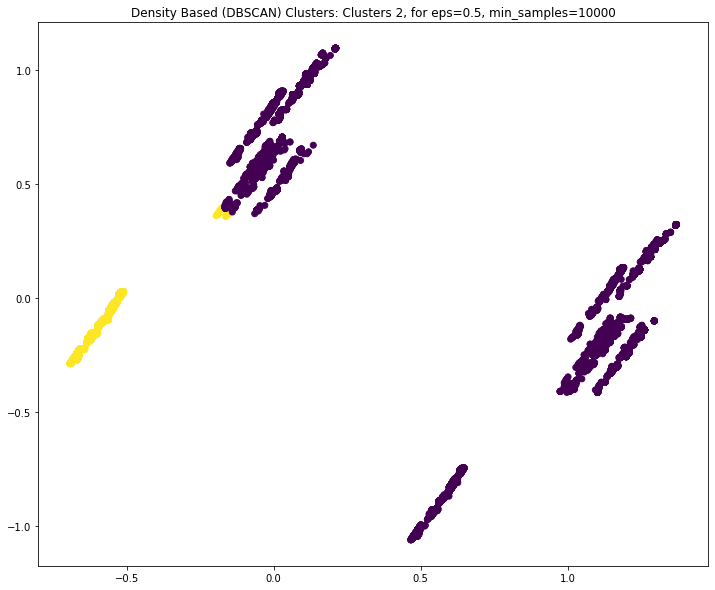

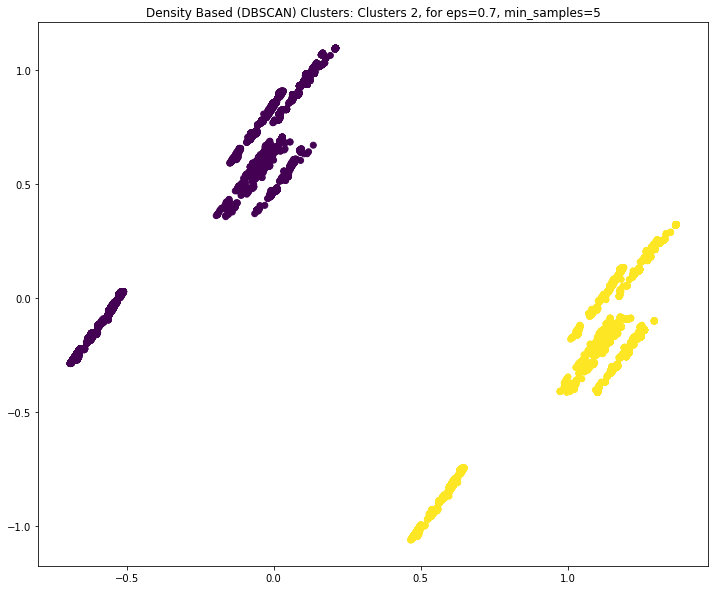

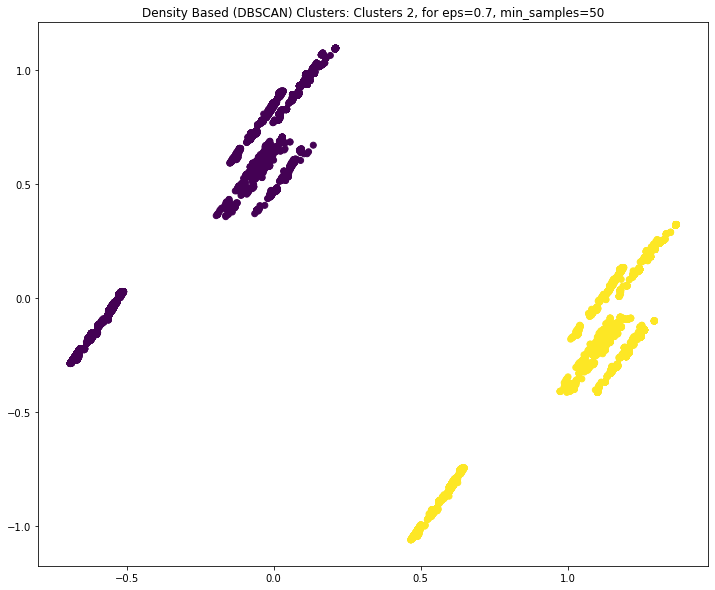

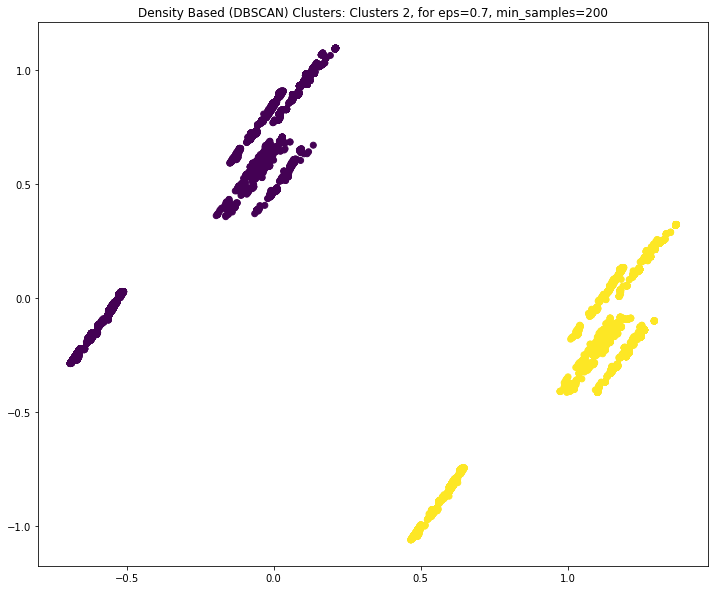

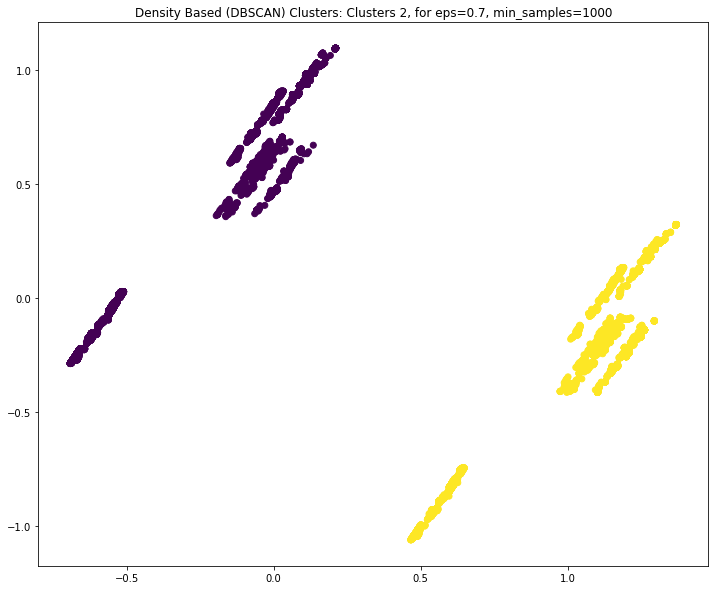

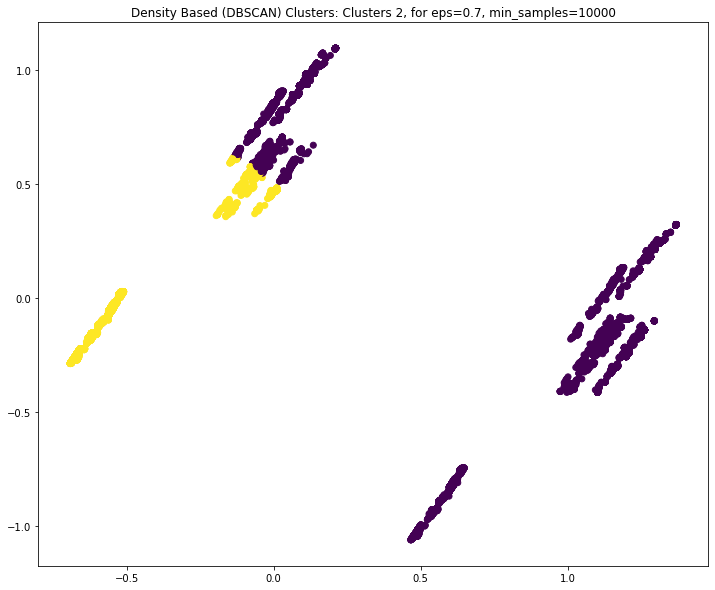

In [118]:
for dbscan_eps in [0.1, 0.3, 0.5, 0.7]:
    for dbscan_min_samples in [5, 50, 200, 1000, 10000]:
        
        dbscan = DBSCAN(eps = dbscan_eps, min_samples = dbscan_min_samples)\
                            .fit(property_sales_data_dummies_scaled_transformed_reduced)
        
        dbscan_clusters = dbscan.labels_

        dbscan_cluster_number = len(pd.Series(dbscan_clusters).unique().tolist())

        plot_clusters(property_sales_data_dummies_scaled_transformed_reduced, dbscan_clusters, 
              create_dbscan_diagram_title(dbscan_cluster_number, dbscan_eps, dbscan_min_samples))

As we could see, for too small (`0.1`) or too large (i.e. `0.5` or larger) values of $\epsilon$ the clustering is sub-optimal. For the rest of the cases, no matter what range the parameters of the DBSCAN algorithms are, it always identifies `4` clusters for our dataset.

We should note that opposite to the KMeans++ Clustering algorithm, DBSCAN behaves well with data which is not shaped in spherical/well-shaped clusters, so this gives us additional confidence that the optimal number of clusters for our dataset is `4`. 

## Cluster Generation

We will generate clusters using each of the algorithms explored above, so that we could analyse their output in the next section.

### KMeans++ Clustering: 4 Clusters

In [119]:
kmeans_clusterer_4_clusters = KMeans(n_clusters = 4)
kmeans_clusterer_4_clusters.fit(property_sales_data_dummies_scaled_transformed_reduced)
kmeans_4_clusters = kmeans_clusterer_4_clusters.predict(property_sales_data_dummies_scaled_transformed_reduced)

### Agglomerative Clusterring: 4 Clusters

In [120]:
agglomerative_clusterer_4_clusters = AgglomerativeClustering(n_clusters=4)
agglomerative_clusterer_4_clusters.fit(property_sales_data_dummies_scaled_transformed_reduced)
agglomerative_4_clusters = agglomerative_clusterer_4_clusters.labels_

### DBSCAN Clustering: 4 Clusters (eps = 0.3, min_samples = 200)

In [121]:
dbscan = DBSCAN(eps=0.3, min_samples=200).fit(property_sales_data_dummies_scaled_transformed_reduced)
dbscan_clusters = dbscan.labels_

## Clustering Results: Analysis

Once we have identified that the most optimal number of clusters for our dataset is `4` we would like to analyse what are the corresponding characteristics of the sold properties in each of the clusters.

For the purpose, we are going to attempt analysing the data in each of the clusters from various standpoints, namely:

**Geographical Location**
This means that we will plot the clustered properties sales using their geographical coordinates to attempt understand visually whether geographical location of the properties is a significant factor in the clustering

**Word Cloud** 
As the clustering could be difined as a categorisation without category labels, we will try to generate word cloud for each cluster with the features of the sold properties which are statistically significant

**Pivot Plots**
Ultimately we will approach the clustered data using the pivot tables for the highly expressed features in order to find any rules of the way how the clusters are organised

### Auxilliary Functions for Clustering Analysis

In [122]:
def plot_clustered_properties_by_geo_location(property_sales_data, predicted_clusters, title):
    """Plots clustered data using geo coordinates (without plotting the map itself). 
    The assumptions is that the number of records in the `property_sales_data` must match those in 
    `predicted_clusters`.
    
    Parameters:
    property_sales_data: Dataset which contains geo coordinates of sold properties
    predicted_clusters: The cluster type of a property
    title: Plot title
    """
    plt.figure(figsize = (12, 10))
    sns.scatterplot(property_sales_data.lat, property_sales_data.lon, hue = predicted_clusters, 
                palette = sns.color_palette('hls', np.unique(predicted_clusters).shape[0]))
    plt.title(title)
    plt.show()

## KMeans++ Clustering: 4 Clusters

In [123]:
kmeans_clusterer_4_clusters = KMeans(n_clusters = 4)

In [124]:
kmeans_clusterer_4_clusters.fit(property_sales_data_dummies_scaled_transformed_reduced)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [125]:
kmeans_4_clusters = kmeans_clusterer_4_clusters.predict(property_sales_data_dummies_scaled_transformed_reduced)

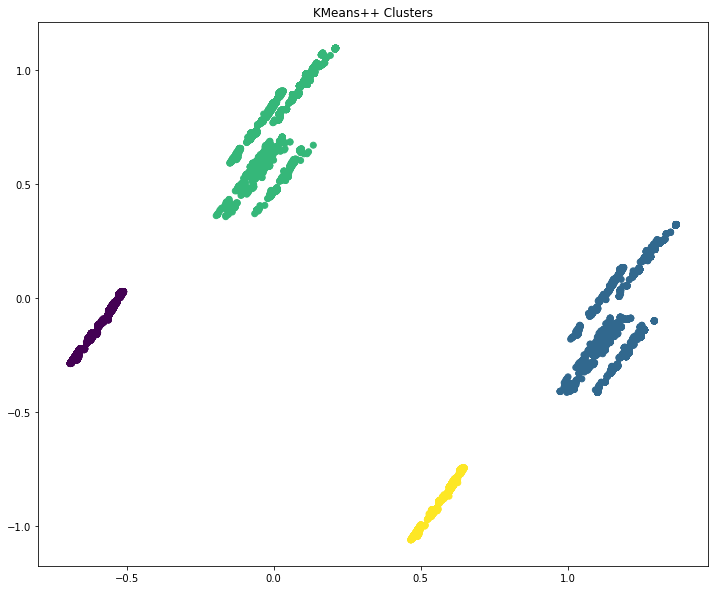

In [126]:
plot_clusters(property_sales_data_dummies_scaled_transformed_reduced, kmeans_4_clusters, "KMeans++ Clusters")

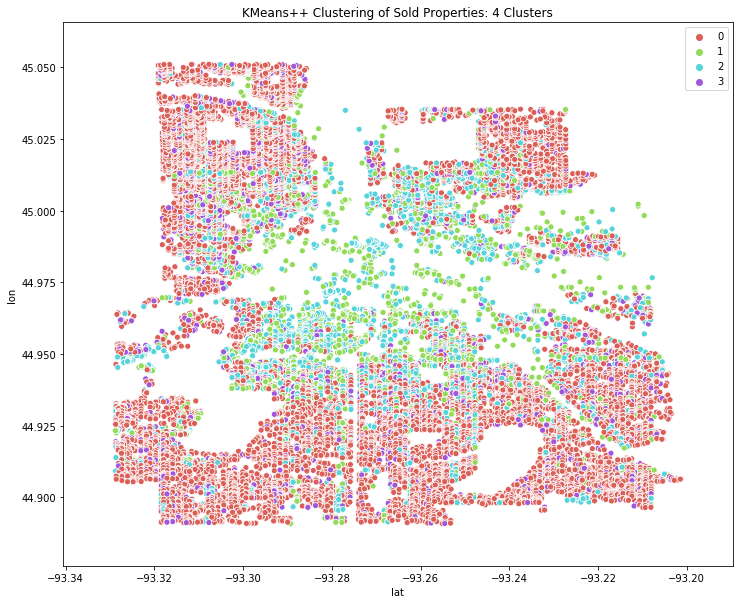

In [127]:
plot_clustered_properties_by_geo_location(property_sales_data, kmeans_4_clusters, 
                                          "KMeans++ Clustering of Sold Properties: 4 Clusters")

Plotting the clustered data on a geographical map does not reveal any specific structure around the clustered data. 

In [128]:
plot_clustered_data(property_sales_data, kmeans_4_clusters, 'lat', 'lon')

NameError: name 'plot_clustered_data' is not defined

## Agglomerative Clustering

### Agglomerative Clustering for Optimal Number of Clusters (4)

Apparently, the optimal number of clusters is 4, which aligns with our findings from the KMeans++ Clustering and the application of the Elbow Method. We :

In [ ]:
agglomerative_clusterring_4_clusters = AgglomerativeClustering(n_clusters=4) # the default configuration work

In [ ]:
agglomerative_clusterring_4_clusters.fit(property_sales_data_dummies_scaled_transformed_reduced)

In [ ]:
agglomerative_clusters_4 = agglomerative_clusterring_4_clusters.labels_

In [ ]:
plot_clusters(property_sales_data_dummies_scaled_transformed_reduced, agglomerative_clusters_4, \
              "Agglomerative Clusters: 4 Clusters")

In [ ]:
plot_clustered_properties_by_geo_location(property_sales_data, agglomerative_clusters_4, \
                                          "Agglomerative Clustering of Sold Properties: 4 Clusters")

In [ ]:
plot_clustered_data(property_sales, agglomerative_clusters_4, 'lat', 'lon')

## Density Based Spatial Clustering for Applications with Noise (DBSCAN)  Clustering 

In [ ]:
dbscan = DBSCAN(eps=0.3, min_samples=200).fit(property_sales_data_dummies_scaled_transformed_reduced)

Please note that with more than `50` min_samples always the number of clusters is 4. Otherwise is 2.

In [ ]:
dbscan_clusters = dbscan.labels_
dbscan_clusters

In [ ]:
len(pd.Series(dbscan_clusters).unique().tolist())

In [ ]:
plot_clusters(property_sales_data_dummies_scaled_transformed_reduced, dbscan_clusters, \
              "Density Based (DBSCAN) Clusters")

In [ ]:
plot_clustered_properties_by_geo_location(property_sales_data, dbscan_clusters, \
                                          "Density Based Spatial Clustering for Applications with Noise (DBSCAN) Clustering of Sold Properties: epsilon 0.3, min samples 200")

In [ ]:
plot_clustered_data(property_sales, dbscan_clusters, 'lat', 'lon')

## Labeling Clusters

In [ ]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
property_sales_data

In [ ]:
temp_data = property_sales_data

In [ ]:
temp_data['position'] = property_sales.geometry
temp_data

In [ ]:
def clustered_samples(data, clusters):
    clustered_data = data
    clustered_data['cluster'] = clusters
#     clustered_data.drop(columns=['cluster'], axis = 1)
#     clustered_data['position'] = "(" + dataframe["Year"].map(str) + dataframe["quarter"]"({:.2f},{:.2f})".format(clustered_data['lat'],clustered_data['lon'])
    return clustered_data

In [ ]:
kmeans_cl = clustered_samples(temp_data, kmeans_4_clusters)
kmeans_cl

In [ ]:
def create_cluster_name(cluster, category):
    size = len(cluster[cluster.category == category])
    ratio = (size / len(kmeans_cl)) * 100
    title = "Cluster {} [size: {}, ratio: {:.2f}%]".format(category, size, ratio)
    return title

In [ ]:
def print_cluster_info(cluster):
    categories = pd.Series(cluster.category).unique()
    for category in categories:
        print(create_cluster_name(cluster, category))

In [ ]:
aggl_cl = clustered_samples(temp_data, agglomerative_clusterring_4_clusters)

In [ ]:
aggl_cl[aggl_cl.category == 1].head(10)

In [ ]:
dbscan_cl = clustered_samples(temp_data, dbscan_clusters)

In [ ]:
# dbscan_cl[dbscan_cl.category == 1].head(10)

In [ ]:
np.array_equal(kmeans_cl['category'].tolist(), aggl_cl['category'].tolist())

In [ ]:
np.array_equal(kmeans_cl['category'].tolist(), dbscan_cl['category'].tolist())

In [ ]:
def convert_clustered_samples_to_text(clustered_data):
    x = clustered_data.to_string(header=False,
                                 index=False,
                                 index_names=False,
                                 formatters={
                                     "ward": lambda x: "ward_{}".format(x),
                                     "neighborhood": lambda x: x.replace(" ", ""),
                                     "prop_type": lambda x: x.replace(" ", ""),
#                                      "adjusted_sale_price": lambda x: "${:,.2f}".format(x),
                                     "gross_sale_price": lambda x: "${:,.0f}grs_price".format(x),
#                                      "gross_sale_price": lambda x: "",
#                                                   "lat": lambda x: "({:.2f},{:.2f})".format(x),
#                                                   "lon": lambda x: "{:.2f}lon".format(x),
                                     "position" : lambda point : "({:.2f},{:.2f})".format(point.x, point.y),
                                     "in_rto_study": lambda x: "",
                                     "cluster" : lambda x: "",
                                     "category": lambda x: "",
                                     "lat" : lambda x : "",
                                     "lon": lambda x: ""
                                 }).split('\n')
    lines = [' '.join(ele.split()) for ele in x]
    text = " ".join(line for line in lines)
    text
    return text

In [ ]:
def create_wordcloud(text):
    stopwords = set(STOPWORDS)
    stopwords.update(['hbhd', 'ward', 'lat', 'lon', 'adj_price', 'adj_price', 'POINT'])
    wordcloud = WordCloud(stopwords=stopwords, background_color="white", \
                          collocations = False, max_font_size=40,
                          max_words=30).generate(text)
    return wordcloud

In [ ]:
def plot_wordcloud(wordcloud, title):
#     plt.figure(figsize = (12,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.show()

In [ ]:
def plot_wordcloud_for_clusters(clustered_samples):   
    categories = pd.Series(clustered_samples.category).unique()
    for category in categories:
        cluster_title = create_cluster_name(clustered_samples, category)
        print(cluster_title)
        text = convert_clustered_samples_to_text(clustered_samples)
#         print(text)
        wordcloud = create_wordcloud(text)
        plot_wordcloud(wordcloud, cluster_title)

In [ ]:
print_cluster_info(kmeans_cl)

In [ ]:
# plot_wordcloud_for_clusters(kmeans_cl)

In [ ]:
print_cluster_info(aggl_cl)

In [ ]:
print_cluster_info(dbscan_cl)

In [ ]:
def plot_geolocation_and_wordcloud_for_clusters(all_samples, all_clusters, title):  
    categories = pd.Series(all_samples.category).unique()
    categories_number = len(categories)
#     print(categories_number)
    diagrams_number = 2

#     plt.figure(figsize = (34,30))
#     fig, axes = plt.subplots(nrows=len(categories), ncols=2, figsize=(24,40))
    fig = plt.figure(figsize=(30,45))
#     fig = plt.figure()
    index = 1
    plt.title(title, fontsize=25, fontweight='bold', pad=20)
    plt.axis("off")
    
    for category in range(1,categories_number+1):
        category_index = category - 1
        clustered_samples = all_samples[all_samples.category == category_index]
        cluster = all_samples[all_samples.category == category_index].category
        
        cluster_title = create_cluster_name(clustered_samples, category_index)
        
        axisId1 = categories_number*100 + diagrams_number*10 + index
        index = index + 1
#         print("Cluster " + str(category) + " axisId1: " + str(axisId1))
        ax1 = fig.add_subplot(axisId1)
        
#         print(cluster_title)
        
        
#         print(np.unique(categories).shape[0])
        colour = cm.nipy_spectral(float(category_index) / categories_number)
        sns.scatterplot(clustered_samples.lat, clustered_samples.lon, hue = cluster, 
                        ax=ax1, facecolor= colour, edgecolor=colour, alpha=0.7)
#         plt.title(title)\ax1.yaxis.set_ticks([5, 10])
#         ax1.xaxis.set_ticks([1980,1990, 2000, 2010])
#         ax1.xaxis.set_label_text("")
        ax1.set_title(cluster_title, fontsize=14, fontweight='bold')
        
        axisId2 = categories_number*100 + diagrams_number*10 + index
        index = index + 1
#         print("Cluster " + str(category) + " axisId2: " + str(axisId2))
        
        ax2 = fig.add_subplot(axisId2)
        
        text = convert_clustered_samples_to_text(clustered_samples)
#         print(text)
        wordcloud = create_wordcloud(text)
#         plot_wordcloud(wordcloud, cluster_title)
        ax2.imshow(wordcloud, interpolation='bilinear')
        ax2.axis("off")
#         ax2.box(on=True)
        
#     plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
#                   "with n_clusters = %d" % n_clusters), fontsize=14, fontweight='bold')


#         plt.suptitle("Test test test", fontsize=14, fontweight='bold')

#         df.groupby('country').plot(x='year', y='unemployment', ax=ax1, legend=False)
        

In [ ]:
temp_data

In [ ]:
plot_geolocation_and_wordcloud_for_clusters(kmeans_cl, kmeans_4_clusters, "KMeans++ Clusters: n_clusters=4")

In [ ]:
plot_geolocation_and_wordcloud_for_clusters(aggl_cl, agglomerative_clusterring_4_clusters, "Agglomerative Clusters: n_clusters=4")

In [ ]:
plot_geolocation_and_wordcloud_for_clusters(dbscan_cl, dbscan_clusters, "DBSCAN Clusters: n_clusters=4")

## Analysing Clusters via Pivot Tables

In [ ]:
# now = datetime.now()
# end_time = now.strftime("%H:%M:%S")
# print("End Time =", end_time)

In [ ]:
# print("Duration: ", pd.timedelta_range(end_time, start_time))

In [ ]:
property_sales_data.dtypes

In [ ]:
property_sales_data.head()

In [ ]:
# kmeans_cl.category.
# colours = cm.nipy_spectral(float(i) / n_clusters)
# facecolor=color, edgecolor=color, alpha=0.7

In [ ]:
# table = pd.pivot_table(property_sales_data, values='gross_sale_price', index=['prop_type', 'neighborhood', 'ward'],
# ...                     columns=['C'], aggfunc=np.sum)

In [ ]:
# pd.pivot_table(property_sales_data,index=['category'], 
#                columns=['prop_type', 'neighborhood', 'ward', 'gross_sale_price'], 
#                aggfunc=np.sum)

In [ ]:
def plot_pivot_tables(clustered_data, index_feature, x_label, fig_size_x, fig_size_y):
    sns.set(rc={'figure.figsize':(fig_size_x,fig_size_y)})
    pd.pivot_table(clustered_data, 
                   index = [index_feature], 
                   columns= 'category', 
                   values=['gross_sale_price'],
                   fill_value= 0,
                   aggfunc=np.median)\
        .plot(kind='bar')

    plt.xlabel(x_label)
    plt.ylabel('Gross Sale Price')
    plt.title('Pivot Table: Cluster Comparison by '+ x_label)

def plot_default_sized_pivot_tables(clustered_data, index_feature, x_label):
    fig_size_x = 20
    fig_size_y = 10
    plot_pivot_tables(clustered_data, index_feature, x_label, fig_size_x, fig_size_y)

In [ ]:
clustered_data = temp_data
index_feature = 'prop_type'
x_label = 'Property Type'

plot_default_sized_pivot_tables(clustered_data, index_feature, x_label)

In [ ]:
clustered_data = temp_data
index_feature = 'ward'
x_label = 'Ward'
fig_size_x = 20
fig_size_y = 10

plot_default_sized_pivot_tables(clustered_data, index_feature, x_label)

# sns.set(rc={'figure.figsize':(20,10)})
# pd.pivot_table(kmeans_cl, 
#                index = ['ward'], 
#                columns=['category'], 
#                values=['gross_sale_price'],
#                fill_value= 0,
#                aggfunc=np.median).plot(kind='bar')
# plt.xlabel('Ward')
# plt.ylabel('Gross Sale Price')

In [ ]:
# def remove_outliers(values):
#     mid_quantiles = values.quantile([.25, .75])
#     return np.mean(mid_quantiles)

clustered_data = temp_data
index_feature = 'neighborhood'
x_label = 'Neighbourhood'
fig_size_x = 140
fig_size_y = 20
plot_pivot_tables(clustered_data, index_feature, x_label, fig_size_x, fig_size_y)

# sns.set(rc={'figure.figsize':(140, 20)})
# pd.pivot_table(kmeans_cl, 
#                index = ['neighborhood'], 
#                columns='category', 
#                values=['gross_sale_price'],
#                fill_value= 0,
#                aggfunc=np.median).plot(kind='bar')
# plt.xlabel('Neighbourhood')
# plt.ylabel('Gross Sale Price')

# Conclusions/Results
_**Results: What did you find?**_

* Clusters are not geographically organised

# Future Work

* `suffix_direction`
* pandas pipelines
* unifying the colours of the clusters across the document
* type neighbourhood names + zone names on the map
* generalise the approach for newer data sets (e.g. 2010-2013)

TBC

# References

1. [Property Sales 2002-2005, Minneapolis, Minnesota, USA](https://data.world/minneapolismn/342cfcca2eae40838adf5602299dfcd4-0)
2. [Open Minneapolis, Property Sales 2002-2005](http://opendata.minneapolismn.gov/datasets/342cfcca2eae40838adf5602299dfcd4_0)



https://www.elsevier.com/connect/11-steps-to-structuring-a-science-paper-editors-will-take-seriously